# Exploratory Data Analysis Notebook

Welcome to the Exploratory Data Analysis (EDA) Notebook. EDA is all about understanding the data, gaining insights, and identifying patterns which will inform how we model the data.

In this part of the project, we're going to dig into our movie data to see what makes a movie successful. We're looking at success in three different ways:

**Return on Investment (ROI):** 
ROI measures the profitability of a movie, calculated as revenue divided by budget. It's important for investors to gauge the financial success of a movie.

**Rating Metric:**
Movie ratings are important as they show how audiences respond to a movie. We'll combine ratings from various sources for a comprehensive view of a movie's reception.

**Awards Metric:**
Awards and nominations indicate a movie's quality and industry acceptance. They can impact a movie's reputation and financial success. We'll track these to gauge industry recognition.

We'll analyze our data to see how aspects like genre or release month affect these success metrics. This analysis will be useful when we later build our model to predict movie success.

## Objectives:
- **Distribution Analysis**: Understanding the distribution of various features.
- **Outlier Detection**: Detecting and handling outliers.
- **Correlation Analysis**: Identifying relationships between different variables.
- **Trend Analysis**: Discovering trends within the data.
- **Feature Engineering**: Creating new features to better capture the underlying patterns in the data.

## Dataset:
In this notebook, I will be working with the cleaned dataset located at [`./data/cleaned/movies_dataset.parquet`](https://github.com/olgazju/ml_camp_2023/blob/main/midterm_project/data/cleaned/movies_dataset.parquet), which is the result of the cleaning process from Data Cleaning Notebook.


In [1191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

In [1192]:
df = pd.read_parquet('../data/cleaned/movies_dataset.parquet')

In [1193]:
# Set the float format to display the entire number
pd.options.display.float_format = '{:.2f}'.format
df.describe()

release_year  release_month  runtime  tmdb_popularity  tmdb_rating  \
count       7485.00        7485.00  7485.00          7485.00      7485.00   
mean        1999.46           6.93   108.98            18.79        63.11   
std           14.83           3.38    22.24            19.96         9.89   
min         1947.00           1.00     0.00             0.00         0.00   
25%         1992.00           4.00    94.00             8.38        58.00   
50%         2004.00           7.00   105.00            14.16        63.78   
75%         2010.00          10.00   120.00            22.59        69.43   
max         2023.00          12.00   310.00           376.69       100.00   

       tmdb_vote_count  oscar_won  oscar_nominated  bafta_won  \
count          7485.00    7485.00          7485.00    7485.00   
mean           1753.43       0.14             0.22       0.01   
std            3227.62       0.73             0.81       0.10   
min               0.00       0.00             0.00       0.00   
25%             130.00       0.00             0.00       0.00   
50%             543.00       0.00             0.00       0.00   
75%            1794.00       0.00             0.00       0.00   
max           34612.00      11.00            11.00       4.00   

       bafta_nominated  awards_won  awards_nominated  rotten_tomatoes_rating  \
count          7485.00     7485.00           7485.00                 6257.00   
mean              0.02        5.96             11.37                   56.21   
std               0.21       15.15             23.95                   27.98   
min               0.00        0.00              0.00                    0.00   
25%               0.00        0.00              1.00                   33.00   
50%               0.00        1.00              4.00                   59.00   
75%               0.00        5.00             11.00                   81.00   
max               5.00      245.00            337.00                  100.00   

       metacritic_rating  imdb_rating  imdb_votes  adjusted_budget  \
count            5565.00      7478.00     7482.00          7485.00   
mean               55.33        63.55    99282.91      44291629.38   
std                18.24        10.76   191830.37      55106777.88   
min                 1.00        12.00        6.00          1929.38   
25%                42.00        57.00     8164.00       8042376.92   
50%                56.00        64.00    32543.50      25336974.65   
75%                68.00        71.00   105424.75      56411798.83   
max               100.00        93.00  2802199.00     512244953.43   

       adjusted_revenue  adjusted_boxoffice  
count           7485.00             5881.00  
mean       132477545.85         81585304.61  
std        261200915.27        133013103.93  
min             1387.86              153.56  
25%          7596025.00          6679396.95  
50%         38989575.51         37588369.17  
75%        134424106.96        101051095.47  
max       4254454876.30       2326748295.11

## Labels

### 1. ROI

First, I'll calculate ROI, which is the Return on Investment for a movie. It's calculated by subtracting the budget from the total revenue and then dividing by the budget.

Formula: (revenue - budget) / budget * 100%

Why use the revenue and budget columns for ROI instead of the BoxOffice column? The revenue column includes global earnings, not just box office sales, but also from home video, TV rights, and merchandise. Also, the revenue and budget columns are more complete than the BoxOffice column, which has many missing values.


In [1194]:
df[['adjusted_budget', 'adjusted_revenue', 'adjusted_boxoffice']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7485 entries, 0 to 7929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adjusted_budget     7485 non-null   float64
 1   adjusted_revenue    7485 non-null   float64
 2   adjusted_boxoffice  5881 non-null   float64
dtypes: float64(3)
memory usage: 233.9 KB


Examine the revenue and budget characteristics in our dataset. Compare the data in both original and log-transformed formats.

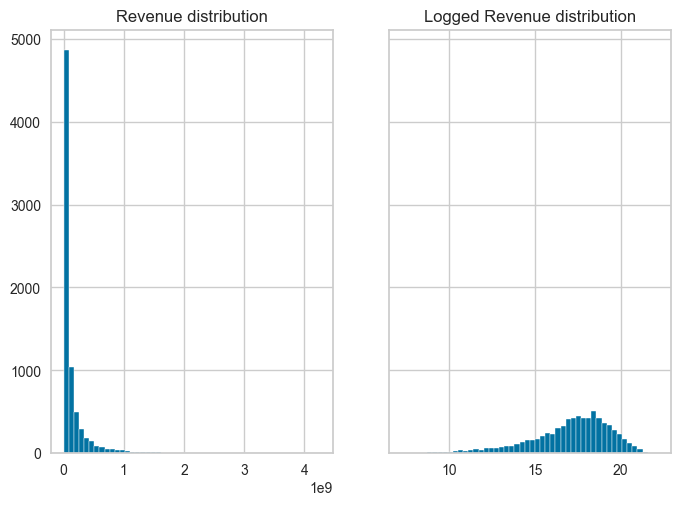

In [1195]:
#Plot movie revenue data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_revenue'], bins=50)
axs[0].set_title('Revenue distribution')
axs[1].hist(np.log(df['adjusted_revenue']), bins=50)
axs[1].set_title('Logged Revenue distribution')
plt.show()

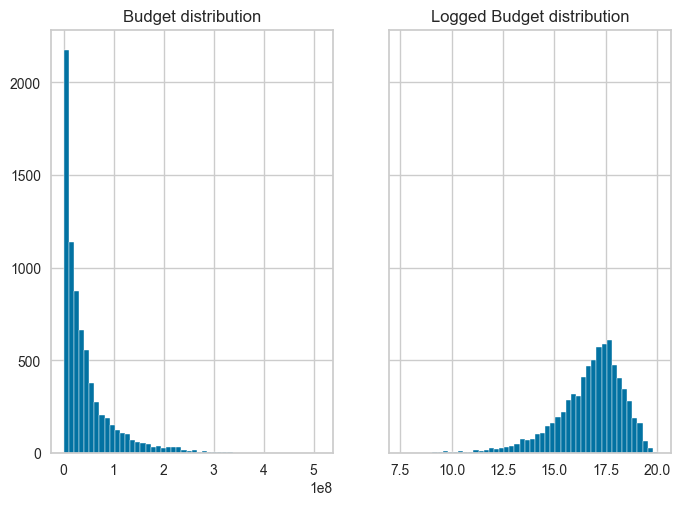

In [1196]:
#Plot movie budget data both logged and non logged
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df['adjusted_budget'], bins=50)
axs[0].set_title('Budget distribution')
axs[1].hist(np.log(df['adjusted_budget']), bins=50)
axs[1].set_title('Logged Budget distribution')
plt.show()

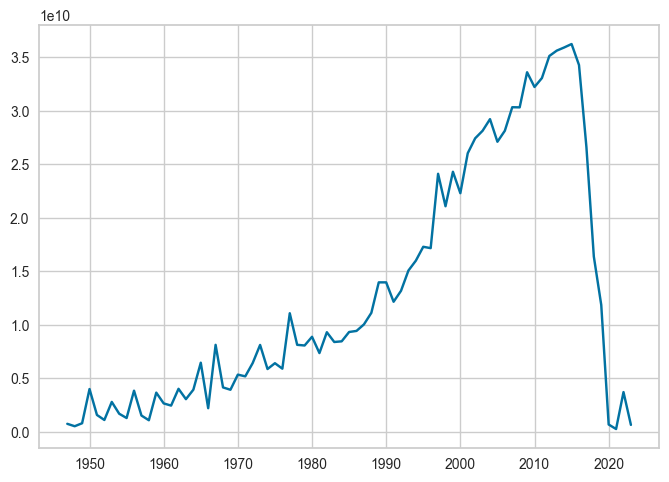

In [1197]:
#Print out yearly adjusted revenue
plot_rev = df.groupby(['release_year'])['adjusted_revenue'].agg('sum')
plt.plot(plot_rev )

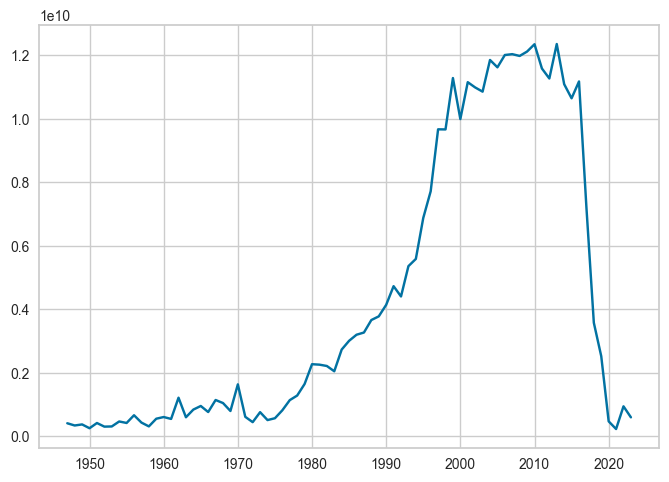

In [1198]:
#Print out yearly adjusted budget
plot_rev = df.groupby(['release_year'])['adjusted_budget'].agg('sum')
plt.plot(plot_rev)

#### Note on Revenue and Budget Drop After 2015

The graphs above show a drop in yearly adjusted revenue and adjusted budget around 2015. This drop matches with a decrease in the number of movies in the dataset during the same period on the graph below. So, the drop in revenue and budget is likely due to having fewer movies in the dataset after 2015, not a real decrease in the movie industry revenue or budget.


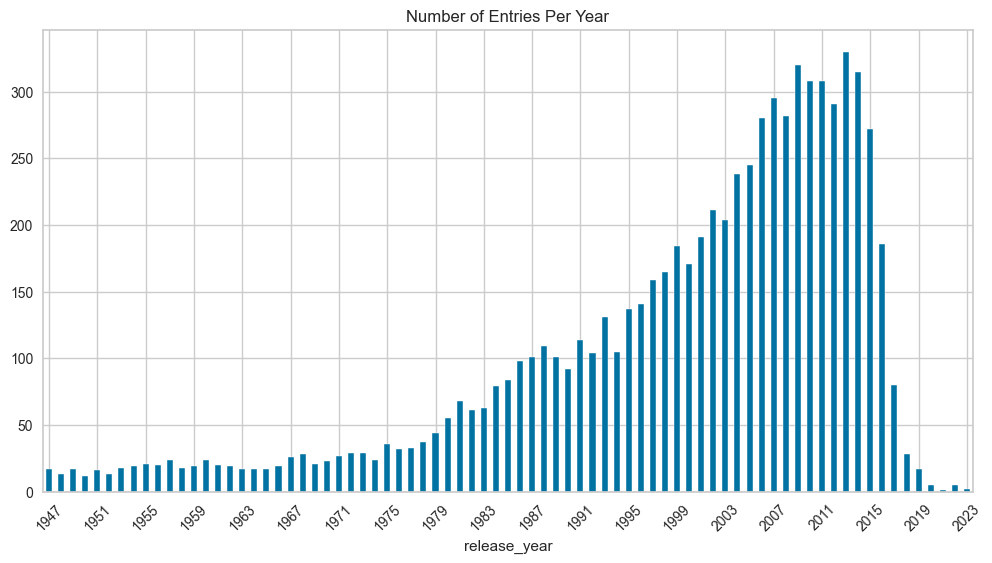

In [1199]:
entries_per_year = df.groupby('release_year').size()
entries_per_year.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Entries Per Year')
plt.xticks(rotation=45) 
plt.locator_params(axis='x', nbins=20)
plt.show()


Formula ROI = (revenue - budget) / budget * 100%

In [1200]:
df['adjusted_ROI'] = ((df['adjusted_revenue'] - df['adjusted_budget']) / df['adjusted_budget']) * 100


In [1201]:
df[['adjusted_ROI']].describe().style

It's clear that the ROI distribution is heavily skewed with some extreme outliers. The big gap between the maximum value and the 75th percentile, as well as the high standard deviation, show there are some extreme values in our data.

Next, I'll identify the percentile of these outliers and explore which movies they are and how many there are.

0.75      295.57
0.95     1340.58
0.99     6209.87
0.99    10767.43
1.00   414298.50
Name: adjusted_ROI, dtype: float64


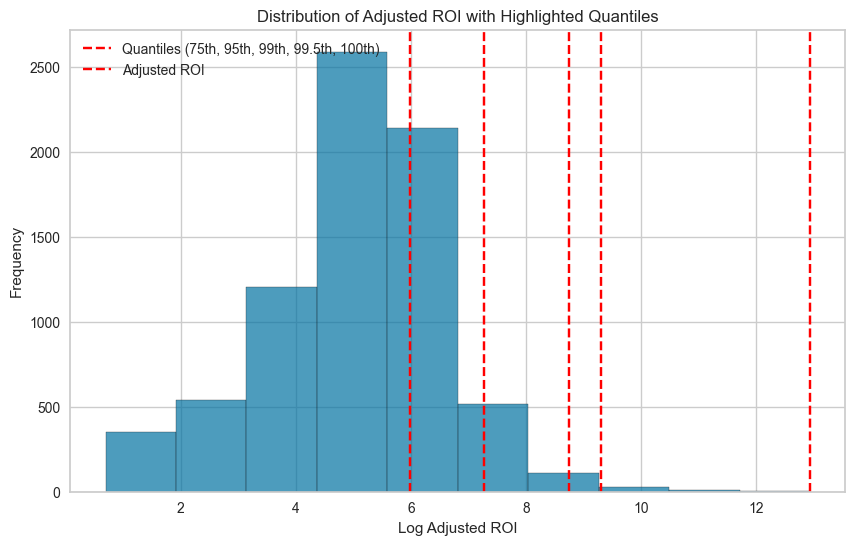

In [1202]:
set_df = df.copy()
percentiles = df['adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])
print(percentiles)

# let's see quantiles on the graph, but first let's apply log adjusted_ROI for better visualization and analysis

# remove the negative numbers by doing a shift in ROI data
set_df['log_adjusted_ROI'] = np.log1p(set_df['adjusted_ROI'] - set_df['adjusted_ROI'].min() + 1)
log_quantiles = set_df['log_adjusted_ROI'].quantile([0.75, 0.95, 0.99, 0.995, 1])

plt.figure(figsize=(10, 6))
plt.hist(set_df['log_adjusted_ROI'], bins=10, edgecolor='k', alpha=0.7)
for quantile in log_quantiles:
    plt.axvline(x=quantile, color='red', linestyle='--')
plt.xlabel('Log Adjusted ROI')
plt.ylabel('Frequency')
plt.title('Distribution of Adjusted ROI with Highlighted Quantiles')
plt.legend(['Quantiles (75th, 95th, 99th, 99.5th, 100th)', 'Adjusted ROI'])
plt.grid(True)
plt.show()


So you can see that outliers from the right side is somewhere between 99.5% and 100%. Let's see the list of the most profitable movies

In [1203]:
quantile_99 = set_df['adjusted_ROI'].quantile(0.995)
max_value = set_df['adjusted_ROI'].max()  # This corresponds to the 100th percentile

count_between = set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)].shape[0]

print(f'Number of values between 99th and 100th percentiles: {count_between}')

set_df[(set_df['adjusted_ROI'] > quantile_99) & (set_df['adjusted_ROI'] <= max_value)][['title', "adjusted_ROI", "adjusted_budget", "adjusted_revenue"]].sort_values(by='adjusted_ROI', ascending=False)


Number of values between 99th and 100th percentiles: 38


title  adjusted_ROI  \
2099                          the blair witch project     414298.50   
4686                                      deep throat     399900.00   
1937                                 1 night in paris     178631.01   
5325                              paranormal activity      89832.93   
2607                                lady frankenstein      69741.50   
1961                            aloha, bobby and rose      58233.33   
581                                    pink flamingos      49900.00   
7464                                      the gallows      42864.41   
953                                        open water      41952.27   
3699                            behind the green door      41566.67   
3456                                         monopoly      37687.12   
998                      the texas chain saw massacre      36252.94   
2271                                          mad max      28471.43   
273                                       el mariachi      28148.03   
4712                                 the stewardesses      26900.00   
3015                         night of the living dead      26215.79   
4548                                     the mistress      26182.00   
2745                                            rocky      22425.04   
30    alice in wonderland: an x-rated musical fantasy      22400.00   
5273                                        halloween      21522.77   
3702                               the zombie diaries      21405.38   
337                             the way of the dragon      20669.23   
1938                                              joe      18125.71   
5064                                american graffiti      17918.02   
40                                  let's do it again      16757.14   
2663                      a polish vampire in burbank      16566.67   
3586                                      blood feast      16226.53   
535                                        easy rider      14900.00   
3316                        the legend of boggy creek      13650.00   
4677                                             once      12844.07   
4364                                napoleon dynamite      11429.52   
5990                                           clerks      11327.49   
5329                                     lady vampire      11011.11   
4410                         ...and god created woman      10900.00   
2289                                      keeping mum      10885.03   
4675                                           vixen!      10858.90   
8                                count yorga, vampire      10837.50   
1541                              the hills have eyes      10769.57   

      adjusted_budget  adjusted_revenue  
2099        109360.89      453189876.90  
4686        182158.87      728635491.61  
1937          8999.42       16084753.84  
5325        313242.65      281708294.19  
2607       1485775.06     1037687589.32  
1961        343970.94      200649716.98  
581          88069.86       44034927.54  
7464        127646.05       54842372.51  
953         213625.37       89834320.23  
3699        428952.00      178730000.00  
3456          3670.22        1386868.56  
998         506401.67      184091900.00  
2271       1506293.91      430369688.39  
273          15558.12        4394863.03  
4712        825654.89      222926820.65  
3015        981242.89      258221813.03  
4548         29410.16        7729578.78  
2745       5229621.34     1177974309.71  
30         2081102.74      468248116.44  
5273       1471659.09      318213449.09  
3702         13995.65        3009816.74  
337         947226.14      196731582.73  
1938        827947.20      150899266.19  
5064       5246321.27      945283111.11  
40          387411.11       65306444.44  
2663          9042.89        1507147.82  
3586        242557.98       39601303.36  
535        3320666.67      498100000.00  
3316       1160252.03      159534653.94  
4677        236811

I checked first 2 outliers - [The_Blair_Witch_Project](https://en.wikipedia.org/wiki/The_Blair_Witch_Project) and [Deep_Throat](https://en.wikipedia.org/wiki/Deep_Throat_(film)), and found that they do indeed have exceptionally high ROIs, which seems legitimate.

Additionally, I researched what's considered a good ROI in the movie industry. Most sources suggest that a movie should earn at least three times its budget to be financially successful. This '3x budget' rule accounts for the fact that the production budget typically covers only filming costs. There are additional expenses like marketing, distribution, and operational costs during a movie's release

If you look at ROI distribution you also might notice that ROI=300 is almost 75th percentile.

Based on the '3x its budget' rule, I'll label the ROI to classify movies as hits or flops:

- **ROI < 300% (or 3x its budget): Flop**
  If the ROI is less than 300%, it means the movie didn't sufficiently cover the production budget and additional expenses. This indicates financial underperformance, so I'll label these as 'flops'.

- **ROI ≥ 300% (or 3x its budget): Hit**
  If the ROI is 300% or more, it shows that the movie not only covered its production budget and additional expenses but also made a healthy profit. Therefore, these movies will be labeled as 'hits'. 

In [1204]:
def categorize_roi(roi):
    if roi < 300:
        return 'flop'
    else:
        return 'hit'

df['ROI_category'] = df['adjusted_ROI'].apply(categorize_roi)

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_ROI_category'] = df['ROI_category'].map(label_mapping)

df.drop(['ROI_category', 'adjusted_boxoffice'], axis=1, inplace=True)

### 2. Ratings

In [1205]:
print(df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].info())
df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']].describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Index: 7485 entries, 0 to 7929
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tmdb_rating             7485 non-null   float64
 1   tmdb_vote_count         7485 non-null   int64  
 2   imdb_rating             7478 non-null   float64
 3   imdb_votes              7482 non-null   float64
 4   rotten_tomatoes_rating  6257 non-null   float64
 5   metacritic_rating       5565 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 409.3 KB
None


count     mean       std   min     25%      50%  \
tmdb_rating            7485.00    63.11      9.89  0.00   58.00    63.78   
tmdb_vote_count        7485.00  1753.43   3227.62  0.00  130.00   543.00   
imdb_rating            7478.00    63.55     10.76 12.00   57.00    64.00   
imdb_votes             7482.00 99282.91 191830.37  6.00 8164.00 32543.50   
rotten_tomatoes_rating 6257.00    56.21     27.98  0.00   33.00    59.00   
metacritic_rating      5565.00    55.33     18.24  1.00   42.00    56.00   

                             75%        max  
tmdb_rating                69.43     100.00  
tmdb_vote_count          1794.00   34612.00  
imdb_rating                71.00      93.00  
imdb_votes             105424.75 2802199.00  
rotten_tomatoes_rating     81.00     100.00  
metacritic_rating          68.00     100.00

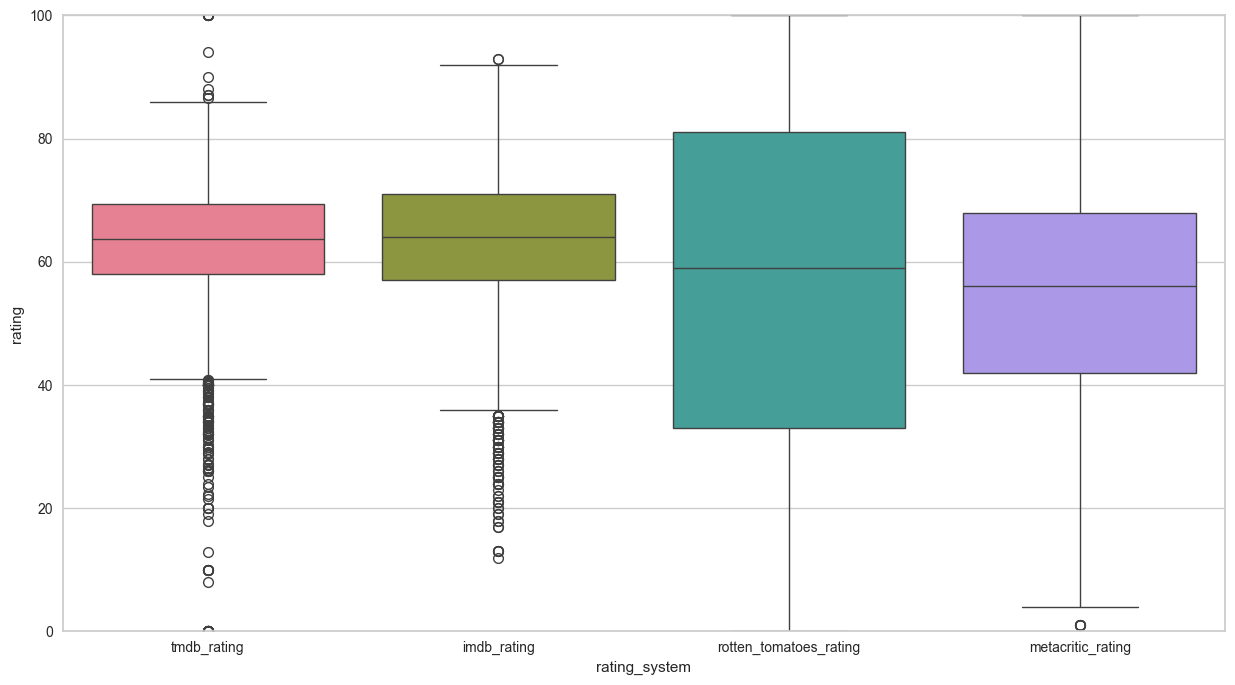

In [1206]:
melted_df = df.melt(value_vars=['tmdb_rating', 'imdb_rating', 'rotten_tomatoes_rating', 'metacritic_rating'],
                    var_name='rating_system', value_name='rating')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.boxplot(x='rating_system', y='rating', data=melted_df, palette="husl", hue='rating_system', ax=ax)
ax.set_ylim([0, 100])  

plt.show()

In [1207]:
zero_counts = (df[['tmdb_rating', 'tmdb_vote_count',  'imdb_rating', 'imdb_votes', 'rotten_tomatoes_rating', 'metacritic_rating']] == 0).sum()

print(zero_counts)


tmdb_rating               20
tmdb_vote_count           20
imdb_rating                0
imdb_votes                 0
rotten_tomatoes_rating    78
metacritic_rating          0
dtype: int64


In our dataset, we have the vote counts for each movie from TMDB (`tmdb_vote_count`) and IMDb (`imdb_votes`). It's known that a movie's rating often depends on its vote count; a movie with more votes generally has a more reliable rating due to a larger voter base, reducing skewed results.

To address this, I'm applying a Weighted Rating Formula. This formula takes into account both the average rating and the number of votes a movie has. This way, it provides a more accurate estimation of a movie's rating, especially for those with fewer votes.

**Adjusting Ratings based on Vote Counts:**

The formula used is the IMDb weighted rating formula:

Weighted Rating(WR) = (v/(v+m))*R + (m/(v+m)) * C
where:

- v is the number of votes for the item,
- m is the minimum number of votes required for the item to be listed,
- R is the average rating of the item,
- C is the mean rating across the whole dataset.

I'm using the 70th percentile (0.70 quantile) as the threshold for the minimum number of votes needed. This means only movies with vote counts in the top 30% of the dataset will have their weighted rating significantly influenced by their own average rating. For movies with fewer votes, the global average rating will play a more substantial role in their weighted rating.

In [1208]:
m = df['tmdb_vote_count'].quantile(0.70)  # minimum votes required to be listed
C = df['tmdb_rating'].mean()  # mean rating across the whole dataset

print('tmdb minimum votes:', m)
print('tmdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['tmdb_vote_count']
    R = x['tmdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_tmdb_rating'] = df.apply(weighted_rating, axis=1)

m = df['imdb_votes'].quantile(0.70)  # minimum votes required to be listed
C = df['imdb_rating'].mean()  # mean rating across the whole dataset

print('imdb minimum votes:', m)
print('imdb mean rating across the whole dataset:', C)

# Function to compute weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['imdb_votes']
    R = x['imdb_rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

df['weighted_imdb_rating'] = df.apply(weighted_rating, axis=1)

df[['imdb_rating', 'imdb_votes', 'weighted_tmdb_rating',  'tmdb_vote_count',  'tmdb_rating','weighted_imdb_rating', 'rotten_tomatoes_rating',	'metacritic_rating']].describe().style

tmdb minimum votes: 1418.0
tmdb mean rating across the whole dataset: 63.10702738810955
imdb minimum votes: 82871.39999999998
imdb mean rating across the whole dataset: 63.55335651243648


The weighted rating formula evens out the ratings, especially for movies with fewer votes. It brings these movies' ratings closer to the average. This reduces extreme ratings for movies with only a few votes, making the overall rating distribution more even. For movies with lots of votes, which reflect a broader audience opinion, the formula has less impact.

This way of adjusting ratings towards the average helps lessen the effect of very high or low ratings from a small number of votes, which could otherwise skew the overall picture.

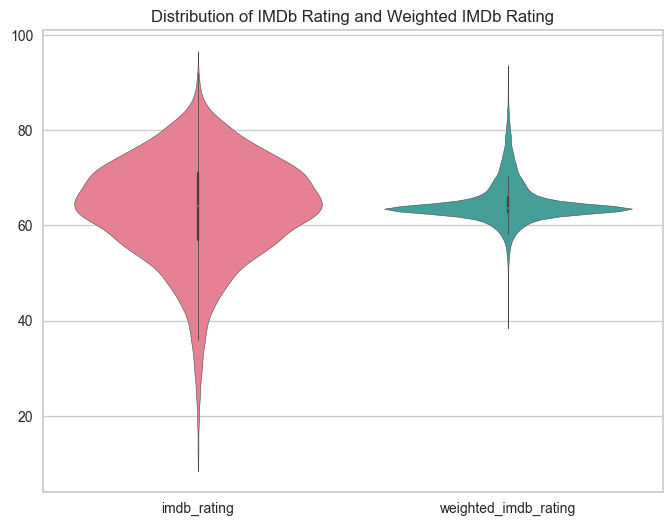

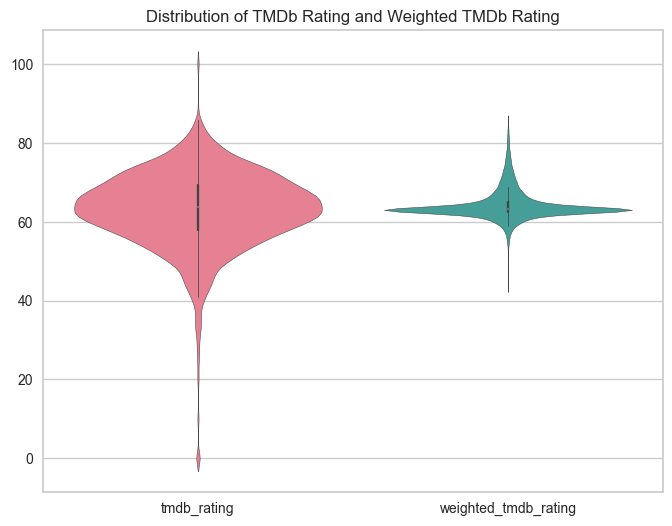

In [1209]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df[['imdb_rating', 'weighted_imdb_rating']], palette="husl")
plt.title('Distribution of IMDb Rating and Weighted IMDb Rating')
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(data=df[['tmdb_rating', 'weighted_tmdb_rating']], palette="husl")
plt.title('Distribution of TMDb Rating and Weighted TMDb Rating')
plt.show()


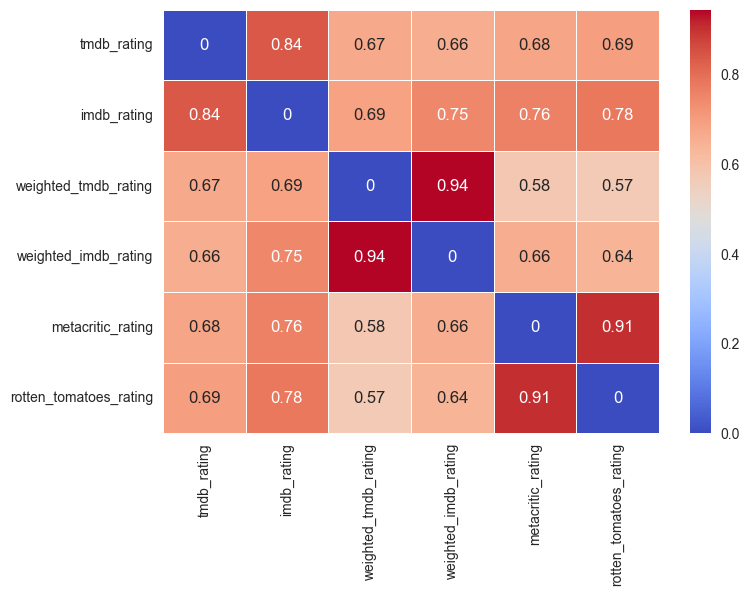

('weighted_tmdb_rating', 'weighted_imdb_rating')


In [1210]:
corr_matrix = df[[ "tmdb_rating", 'imdb_rating', 
                             "weighted_tmdb_rating", 'weighted_imdb_rating', 
                             'metacritic_rating', 'rotten_tomatoes_rating']].corr()

# Compute the correlation matrix between ratings
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm' , linewidth=.5)

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)


The correlation coefficient between weighted_tmdb_rating and weighted_imdb_rating shows a very strong positive relationship. This suggests averaging them separately is a good idea, as they likely reflect similar aspects of a movie's quality.

Also, if weighted_imdb_rating is missing, I'll use just the weighted_tmdb_rating value instead.

In [1211]:
# let's take average number between weighted_imdb_rating and weighted_tmdb_rating 
# if weighted_imdb_rating is null - take weighted_tmdb_rating value
df['average_rating'] = np.where(df['weighted_imdb_rating'].isnull(), 
                                df['weighted_tmdb_rating'], 
                                (df['weighted_tmdb_rating'] + df['weighted_imdb_rating']) / 2)


# let's look at the top rates movies
top_movies = df.sort_values(by='average_rating', ascending=False)
top_movies[['title', 'average_rating']].head(15)


title  average_rating
4852                           the shawshank redemption           88.94
4827                                      the godfather           88.12
6492                                    the dark knight           86.69
6474      the lord of the rings: the return of the king           86.18
4115                                   schindler's list           86.13
4829                              the godfather part ii           85.91
574                                        pulp fiction           85.90
915                                        forrest gump           85.37
2497                                         fight club           85.23
3519                                          inception           85.02
6472  the lord of the rings: the fellowship of the ring           84.92
5711                                       12 angry men           84.77
6769                                       interstellar           84.69
6473              the lord of the rings: the two towers           84.69
4149                                     the green mile           84.00

I'm not going to use metacritic and rotten tomatoes rating in this analysis. It's possible to fill the missing data in those ratings by mean for example, but it still demands to include those 2 ratings into the raiting formula metric which will increase complexity.

Currently for simplicity we aim to categorize movies into 'hit' or 'flop' based on their average ratings.
I chose a simplistic approach to label the top 25% of movies (in terms of average_rating) as 'hit', while the remaining 75% are labeled as 'flop'.

In [1212]:
df['rating_category'] = 'flop' 
top_25_percentile_threshold = df['average_rating'].quantile(0.75)  
df.loc[df['average_rating'] >= top_25_percentile_threshold, 'rating_category'] = 'hit'  

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_rating_category'] = df['rating_category'].map(label_mapping)
df.drop(['rating_category', 
                             'rotten_tomatoes_rating', 'metacritic_rating', 'imdb_rating', 'tmdb_rating',  
                             'weighted_imdb_rating', 'weighted_tmdb_rating', 'tmdb_vote_count', 'imdb_votes'], axis=1, inplace=True)


### 3. Awards

In [1213]:
df[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']].describe()

oscar_won  oscar_nominated  bafta_won  bafta_nominated  awards_won  \
count    7485.00          7485.00    7485.00          7485.00     7485.00   
mean        0.14             0.22       0.01             0.02        5.96   
std         0.73             0.81       0.10             0.21       15.15   
min         0.00             0.00       0.00             0.00        0.00   
25%         0.00             0.00       0.00             0.00        0.00   
50%         0.00             0.00       0.00             0.00        1.00   
75%         0.00             0.00       0.00             0.00        5.00   
max        11.00            11.00       4.00             5.00      245.00   

       awards_nominated  
count           7485.00  
mean              11.37  
std               23.95  
min                0.00  
25%                1.00  
50%                4.00  
75%               11.00  
max              337.00

In [1214]:
# Top 10 movies by oscar_won
top10_oscar_won = df.nlargest(10, 'oscar_won')

# Top 10 movies by bafta_won
top10_bafta_won = df.nlargest(10, 'bafta_won')

# Top 10 movies by awards_won
top10_awards_won = df.nlargest(10, 'awards_won')

print("Top 10 movies by Oscar wins:")
print(top10_oscar_won[['title', 'oscar_won']])

print("\nTop 10 movies by BAFTA wins:")
print(top10_bafta_won[['title', 'bafta_won']])

print("\nTop 10 movies by Total awards won:")
print(top10_awards_won[['title', 'awards_won']])


Top 10 movies by Oscar wins:
                                              title  oscar_won
562                                         ben-hur         11
2532                                        titanic         11
6474  the lord of the rings: the return of the king         11
1355                                west side story         10
3279                                           gigi          9
3632                               the last emperor          9
4109                            the english patient          9
555                               on the waterfront          8
1682                                   my fair lady          8
1806                          from here to eternity          8

Top 10 movies by BAFTA wins:
                                        title  bafta_won
4692                         a bridge too far          4
3056                        strictly ballroom          3
83                       pink floyd: the wall          2
1120                

I looked at additional movie award information on IMDb, specifically at https://www.imdb.com/title/<IMDB_ID>/awards/. The awards_won and awards_nominated columns count the total awards won and nominations, respectively.

Take 'The Lord of the Rings: The Return of the King' or 'Titanic', for example. Our dataset mentions their Oscars but not their BAFTA awards. This might mean our data focuses on the most prestigious award(s) a movie gets.

Next, I'll test if any movie in our dataset has both Oscar and BAFTA awards listed together:

In [1215]:

titles_of_interest = ['titanic', 'the lord of the rings: the return of the king']
filtered_rows = df[df['title'].isin(titles_of_interest)]
print(filtered_rows[['oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']])

non_empty_awards_rows = df[(df['oscar_won'].notnull() & df['oscar_won'] > 0) & (df['bafta_won'].notnull() & df['bafta_won'] > 0)]
print(non_empty_awards_rows)

      oscar_won  oscar_nominated  bafta_won  bafta_nominated  awards_won  \
1206          1                0          0                0           1   
2532         11                0          0                0         126   
6474         11                0          0                0         215   

      awards_nominated  
1206                 3  
2532                83  
6474               124  
Empty DataFrame
Columns: [title, release_year, release_month, original_language, spoken_languages, genres, production_companies, production_countries, runtime, rated, tagline, overview, plot, tmdb_popularity, cast, crew, belongs_to_collection.name, oscar_won, oscar_nominated, bafta_won, bafta_nominated, awards_won, awards_nominated, adjusted_budget, adjusted_revenue, adjusted_ROI, numerical_ROI_category, average_rating, numerical_rating_category]
Index: []

[0 rows x 29 columns]


We can create a Points System to combine these awards into one score. We'll give more points for winning awards and some extra points for nominations. Oscars will get the highest points, followed by BAFTA, and then other awards. We'll also take out the BAFTA and Oscar counts from the total awards number.

Points:

* Oscar Win: 5 points
* Oscar Nomination: 3 points
* BAFTA Win: 4 points
* BAFTA Nomination: 2 points
* Other Award Win: 3 points
* Other Award Nomination: 1 point"

In [1216]:
df['award_points'] = (df['oscar_won'] * 5 + df['oscar_nominated'] * 3 +
                      df['bafta_won'] * 4 + df['bafta_nominated'] * 2 +
                      (df['awards_won'] - df['oscar_won'] - df['bafta_won']) * 3 + 
                      (df['awards_nominated'] - df['oscar_nominated'] - df['bafta_nominated']) * 1)

df[['award_points', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated']]

award_points  oscar_won  oscar_nominated  bafta_won  bafta_nominated  \
0                0          0                0          0                0   
1                0          0                0          0                0   
2               43          4                0          0                0   
4                3          0                0          0                0   
5                3          0                0          0                0   
...            ...        ...              ...        ...              ...   
7925            55          0                0          0                0   
7926            12          0                0          0                0   
7927             3          0                0          0                0   
7928             4          0                0          0                0   
7929             3          0                0          0                0   

      awards_won  awards_nominated  
0              0                 0  
1              0                 0  
2              9                 8  
4              0                 3  
5              0                 3  
...          ...               ...  
7925           8                31  
7926           3                 3  
7927           1                 0  
7928           1                 1  
7929           0                 3  

[7485 rows x 7 columns]

count   7485.00
mean      30.01
std       67.82
min        0.00
25%        2.00
50%        8.00
75%       27.00
max     1069.00
Name: award_points, dtype: float64


/var/folders/_g/dcc1mh151c37cqym56jdsb0w0000gn/T/ipykernel_63998/1283950992.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




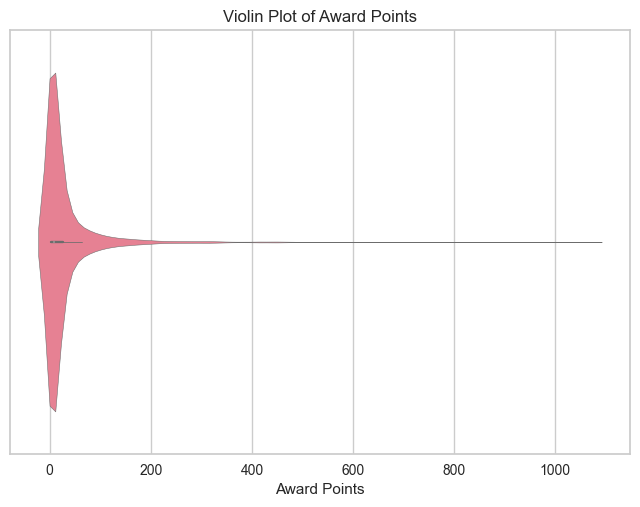

In [1217]:
print(df['award_points'].describe())
sns.violinplot(x=df['award_points'], palette="husl")
plt.title('Violin Plot of Award Points')
plt.xlabel('Award Points')
plt.show()


The top 25% of movies, ranked by award points, are labeled as 'hit', and the rest as 'flop'. This threshold is consistent with the approach used for other metrics like ROI and average ratings.

In [1218]:
# Determine the 75th percentile value
threshold = df['award_points'].quantile(0.75)

df['award_category'] = ['hit' if x >= threshold else 'flop' for x in df['award_points']]

print(df[['award_points', 'award_category']].head())

label_mapping = {
    'flop': 0,
    'hit': 1
}
df['numerical_award_category'] = df['award_category'].map(label_mapping)
df.drop(['award_category', 'oscar_won',   'oscar_nominated', 'bafta_won', 'bafta_nominated', 'awards_won', 'awards_nominated'], axis=1, inplace=True)


   award_points award_category
0             0           flop
1             0           flop
2            43            hit
4             3           flop
5             3           flop


### Labels correlation

Let's look at our labels correlation

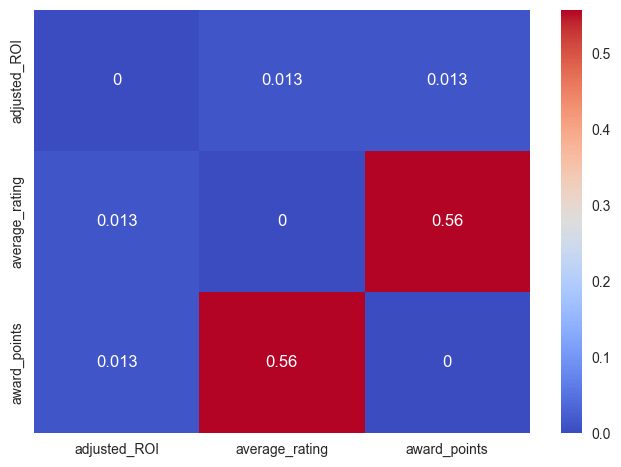

('average_rating', 'award_points')


In [1219]:
corr_matrix = df[[ "adjusted_ROI", 'average_rating', 
                             "award_points"]].corr()

# Compute the correlation matrix between labels
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

max_corr_value = corr_matrix.abs().max().max()
result = corr_matrix.where(corr_matrix == max_corr_value).stack().index.tolist()[0]

print(result)

The correlation number between 'average_rating' and 'award_points' shows that there is a somewhat strong link between the average rating of a movie and the award points it gets. Basically, if a movie has a higher rating, it's somewhat more likely to have more award points too. This makes sense because good movies are often liked by viewers and also get awards.

But, a 0.56 number isn't super strong, so there are probably other things affecting award points that we're not seeing here. And just because two things are linked doesn't mean one causes the other.

There's pretty much no relationship between a movie's Return on Investment (ROI) and its average rating or award points. In other words, just because a movie makes more money (has a higher ROI), it doesn’t mean people will rate it higher or that it will win more awards. And vice versa, a well-rated movie or a movie with lots of awards doesn’t necessarily make more money.

We should consider the fact that raiting label has connection with awards lable when we will chose the model. It should be a model capable of capturing the correlation between labels.

Let's find the most successful movies in each category:

In [1220]:
# Top 10 movies by adjusted_ROI
top10_ROI = df.nlargest(10, 'adjusted_ROI')

# Top 10 movies by average_rating
top10_rating = df.nlargest(10, 'average_rating')

# Top 10 movies by award_points
top10_awards_won = df.nlargest(10, 'award_points')

# To display the top 10 lists
print("Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\nTop 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])

print("\nTop 10 movies by award metric:")
print(top10_awards_won[['title', 'award_points']])


Top 10 movies by ROI metric:
                        title  adjusted_ROI
2099  the blair witch project     414298.50
4686              deep throat     399900.00
1937         1 night in paris     178631.01
5325      paranormal activity      89832.93
2607        lady frankenstein      69741.50
1961    aloha, bobby and rose      58233.33
581            pink flamingos      49900.00
7464              the gallows      42864.41
953                open water      41952.27
3699    behind the green door      41566.67

Top 10 movies by rating matric:
                                              title  average_rating
4852                       the shawshank redemption           88.94
4827                                  the godfather           88.12
6492                                the dark knight           86.69
6474  the lord of the rings: the return of the king           86.18
4115                               schindler's list           86.13
4829                          the godfather pa

In [1221]:
# Anti Top 10 movies by adjusted_ROI
top10_ROI = df.nsmallest(10, 'adjusted_ROI')

# Anti Top 10 movies by average_rating
top10_rating = df.nsmallest(10, 'average_rating')

# To display the top 10 lists
print("Anti Top 10 movies by ROI metric:")
print(top10_ROI[['title', 'adjusted_ROI']])

print("\n Anti Top 10 movies by rating matric:")
print(top10_rating[['title', 'average_rating']])


Anti Top 10 movies by ROI metric:
                                           title  adjusted_ROI
6709                                   java heat        -99.99
5949                               the samaritan        -99.98
6940  the adventurer: the curse of the midas box        -99.97
6565                             the guillotines        -99.96
7727                                    the duel        -99.95
4539                        the velocity of gary        -99.95
6111                  philadelphia experiment ii        -99.94
1488                                   fishtales        -99.93
3983                             the good doctor        -99.91
146                                      absolon        -99.91

 Anti Top 10 movies by rating matric:
                     title  average_rating
4221  dragonball evolution           44.16
4187        disaster movie           45.30
4112        batman & robin           46.03
5126            epic movie           46.08
5746     meet the s

## Features

#### Budget

Including the budget as a feature is important because movies with different budget sizes often perform differently. For example, a movie with a high budget might have different success factors compared to a low-budget movie.

I first thought about grouping the budget into categories like Low, Medium, and High, but it was hard to decide where to draw the lines between these groups without more knowledge about the industry. Then I found that simply using the log of the adjusted budget performs better for my analysis.

In [1222]:
df['log_adjusted_budget'] = np.log(df['adjusted_budget'])

#### Collection

Let's create a feature indicating whether a movie belongs to a collection or not.

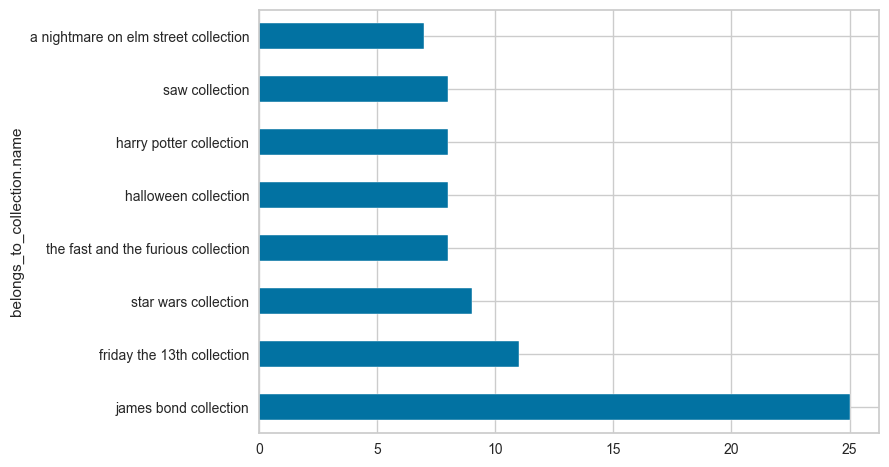

In [1223]:
df['belongs_to_collection.name'].value_counts()
df['belongs_to_collection.name'].value_counts().head(8).plot(kind='barh')
plt.show()

df['collection'] = df['belongs_to_collection.name'].notna()

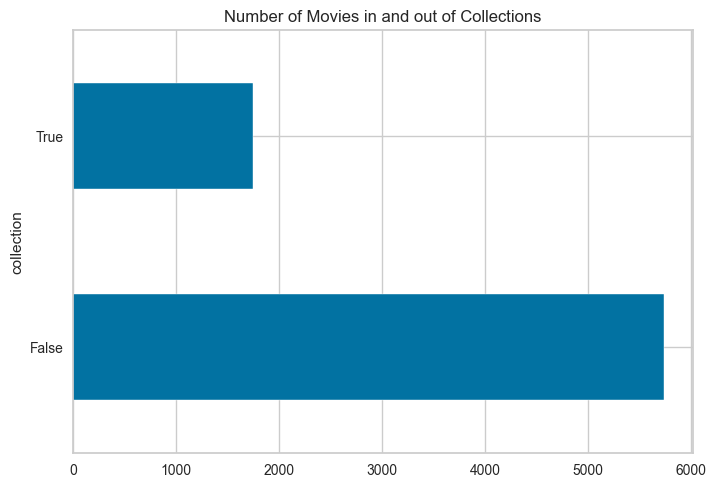

In [1224]:
df['collection'].value_counts()
df['collection'].value_counts().plot(kind='barh')
plt.title('Number of Movies in and out of Collections')

plt.show()

To analyze the distribution of labels for movies that are part of a collection versus those that are not, I need to adjust the data, particularly for the adjusted_ROI, to make it suitable for building boxplots. Since adjusted_ROI contains negative values, shifting this data will ensure a more meaningful visualization.

Additionally, for processing award_points, I will add 1 in the logarithmic transformation (np.log(df["award_points"] + 1)) to avoid division by zero. This adjustment is crucial for handling cases where award_points might be zero, ensuring the transformation is applied consistently across the dataset.

In [1225]:
# Find the minimum value in the adjusted_ROI column
min_value = df['adjusted_ROI'].min()

# If the minimum value is negative, shift all the data by adding the absolute 
# value of the minimum value plus a small constant (e.g., 1)
if min_value < 0:
    shift_constant = abs(min_value) + 1 
    df['shifted_ROI'] = df['adjusted_ROI'] + shift_constant
else:
    df['shifted_ROI'] = df['adjusted_ROI']

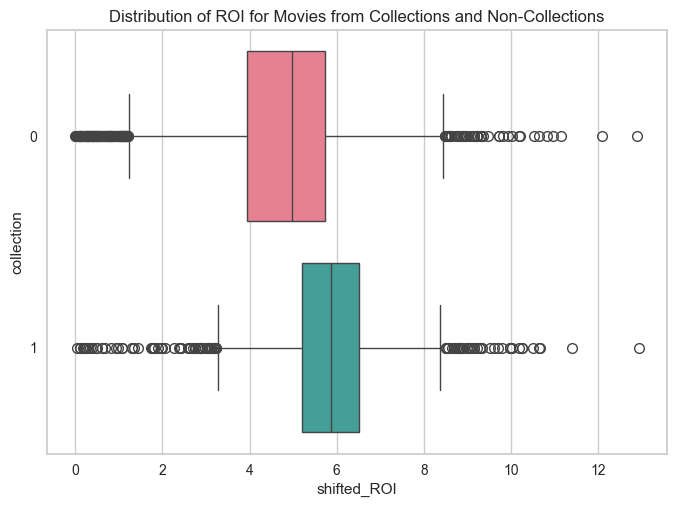

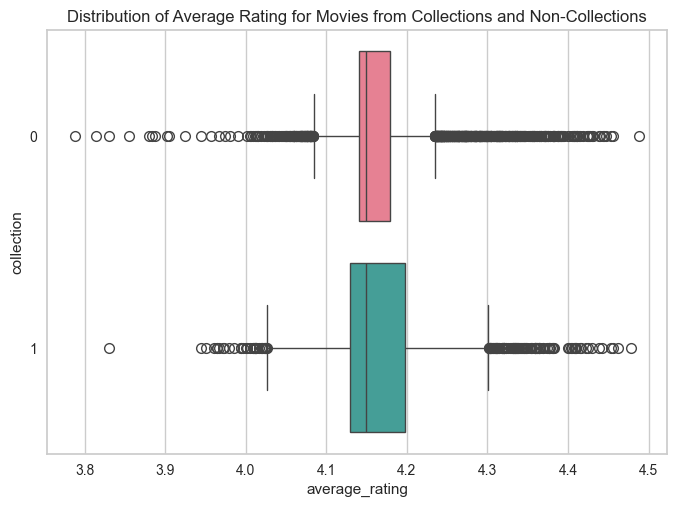

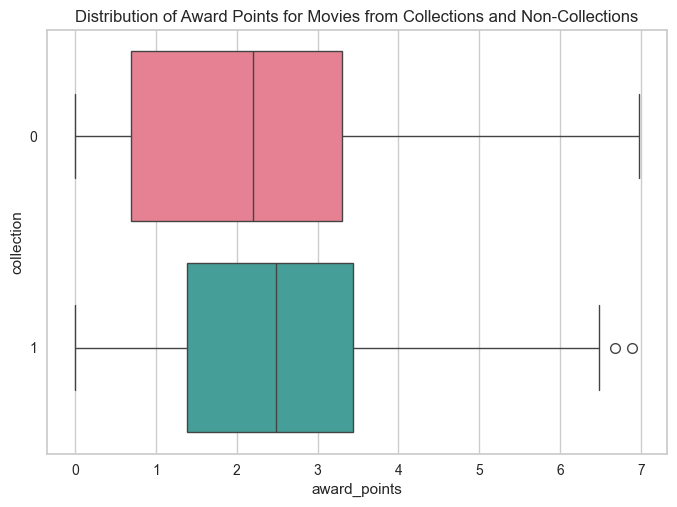

In [1226]:
isCollection_string = df['collection'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of ROI for Movies from Collections and Non-Collections')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of Average Rating for Movies from Collections and Non-Collections')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=isCollection_string, palette="husl", hue=isCollection_string)
plt.title('Distribution of Award Points for Movies from Collections and Non-Collections')
plt.show()

From the box plots, it's evident that movies from collections tend to have a higher ROI and a higher median in awards. They perform similarly in ratings compared to those not in collections.

#### Runtime

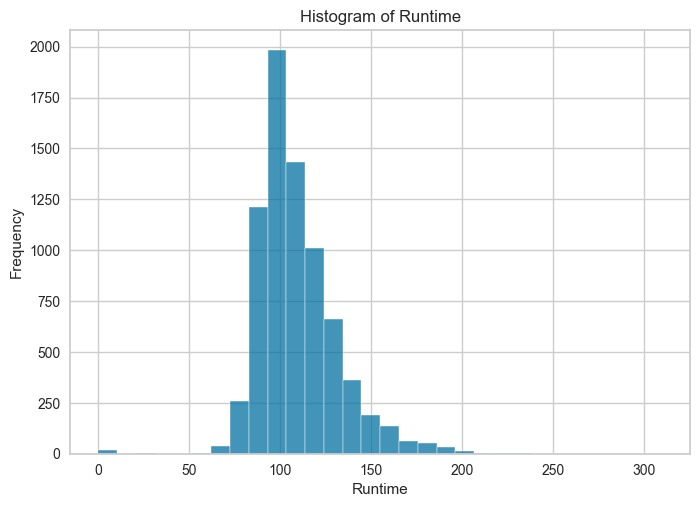

In [1227]:

sns.histplot(df['runtime'], bins=30, kde=False) 
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Histogram of Runtime')
plt.show()

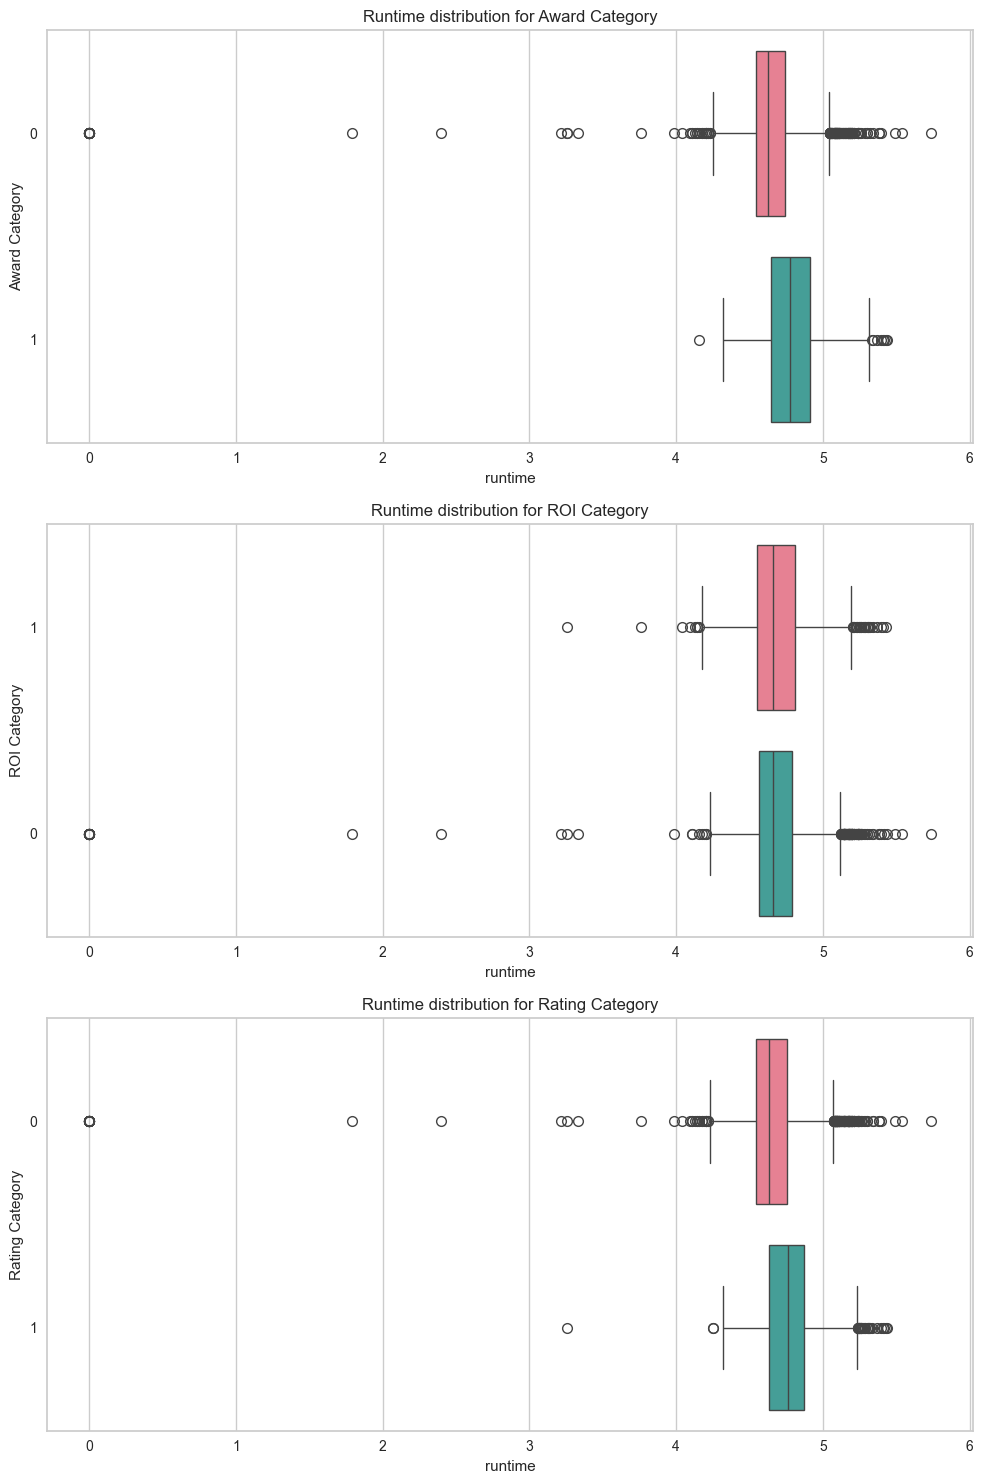

In [1228]:
award_string = df['numerical_award_category'].apply(lambda x: "1" if x==1 else "0")
ROI_string = df['numerical_ROI_category'].apply(lambda x: "1" if x==1 else "0")
rating_string = df['numerical_rating_category'].apply(lambda x: "1" if x==1 else "0")

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting the first boxplot for numerical_award_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=award_string, ax=axs[0], palette="husl", hue=award_string)
axs[0].set_title('Runtime distribution for Award Category')
axs[0].set_ylabel('Award Category')

# Plotting the second boxplot for numerical_ROI_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=ROI_string, ax=axs[1], palette="husl", hue=ROI_string)
axs[1].set_title('Runtime distribution for ROI Category')
axs[1].set_ylabel('ROI Category')

# Plotting the third boxplot for numerical_rating_category
sns.boxplot(x=np.log(df["runtime"] + 1), y=rating_string, ax=axs[2], palette="husl", hue=rating_string)
axs[2].set_title('Runtime distribution for Rating Category')
axs[2].set_ylabel('Rating Category')

plt.tight_layout() 
plt.show()


Regarding the runtime column, my observation from the box plots is that runtime is distributed fairly evenly between the 0 and 1 ROI categories. However, the median runtime is higher for movies in the hit awards category and also for those with higher ratings. This suggests that longer movies might have a better chance of receiving awards and achieving higher ratings.

#### Original language

The most popular movie original language in the dataset is english.

The ratio of English to non-English movies is: 81.66%


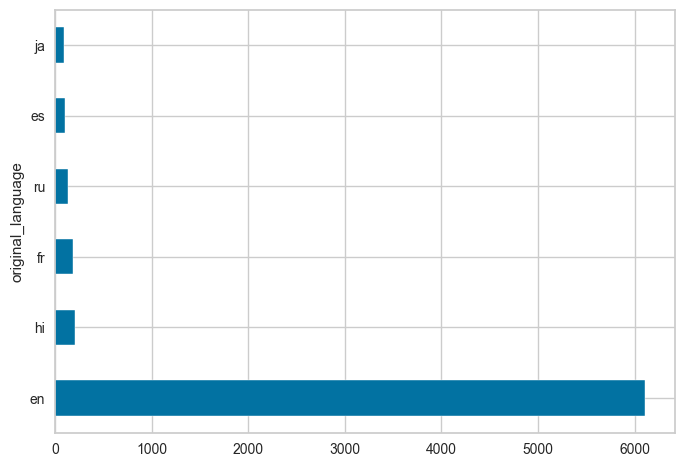

In [1229]:
english_others_ratio = (len(df[df['original_language'] =='en']) / len(df)) * 100
print(f"The ratio of English to non-English movies is: {english_others_ratio:.2f}%")

df['original_language'].value_counts().head(6).plot(kind='barh')
plt.show()

In [1230]:
df[df['adjusted_ROI'] == 0][['title', 'adjusted_revenue', "adjusted_budget", "adjusted_ROI"]]


Empty DataFrame
Columns: [title, adjusted_revenue, adjusted_budget, adjusted_ROI]
Index: []

Let's compare success metrics for non-english and english movies

is_english
1    6112
0    1373
Name: count, dtype: int64


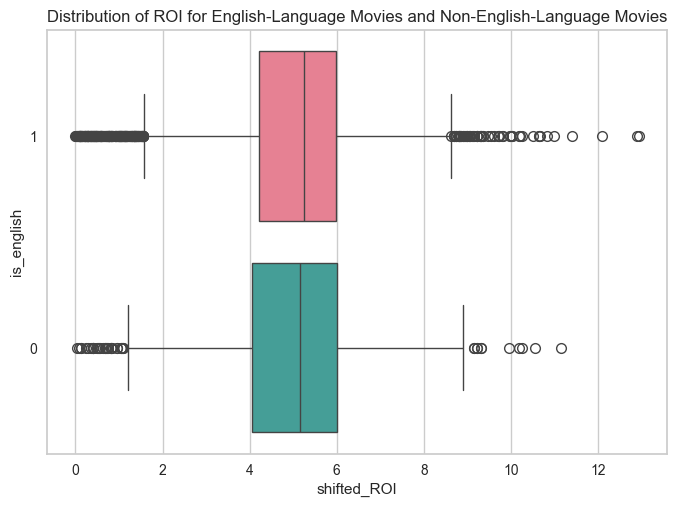

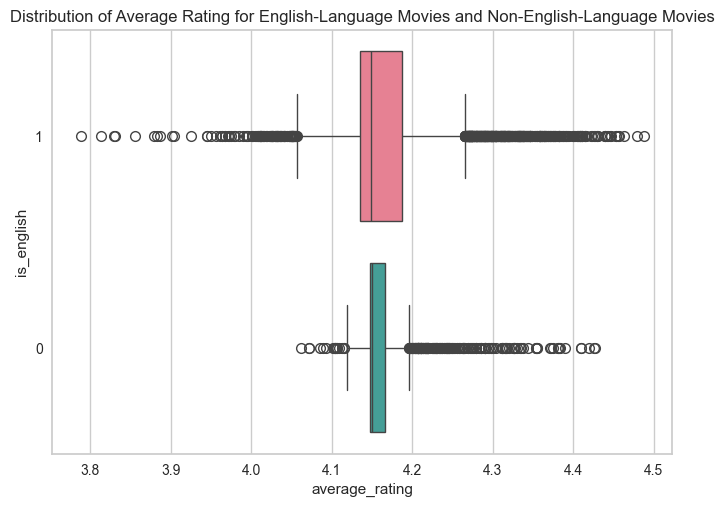

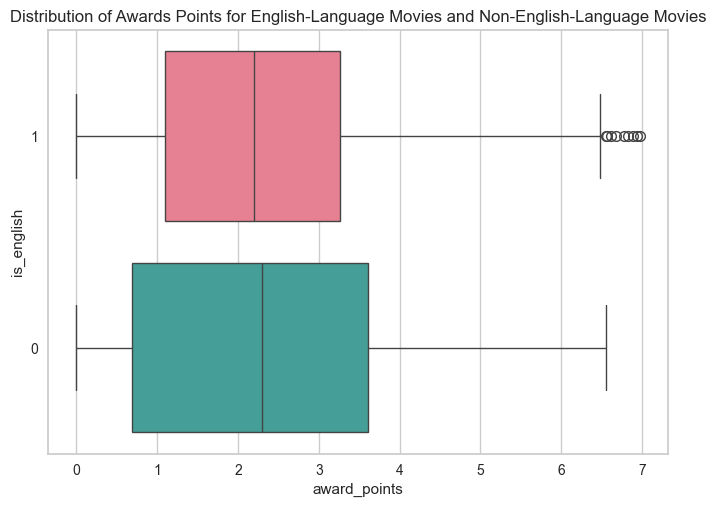

In [1231]:
df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
print(df['is_english'].value_counts())

is_english_string = df['is_english'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of ROI for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of Average Rating for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=is_english_string, palette="husl", hue=is_english_string)
plt.title('Distribution of Awards Points for English-Language Movies and Non-English-Language Movies')
plt.show()

**ROI**

Both English and non-English movies show a big variation in ROI, with high standard deviations and a large difference between their lowest and highest values. English movies generally have a higher median ROI than non-English ones, suggesting they usually earn more in comparison.

**Average Rating**

Non-English movies tend to have slightly higher average and median ratings than English movies. English movies show a wider range of ratings. Non-English movies typically get higher ratings.

**Award Points**

Non-English movies are associated with a bit higher median number of award points, indicating a possible higher level of award recognition for non-English movies in this dataset.

#### Title, overview, tagline and plot

I'm creating a word cloud from the combined text of columns like 'title', 'overview', 'plot', and 'tagline'. By merging these texts and generating a word cloud, I can visually analyze the most frequent words in our dataset, offering insights into common themes and topics in the movies.

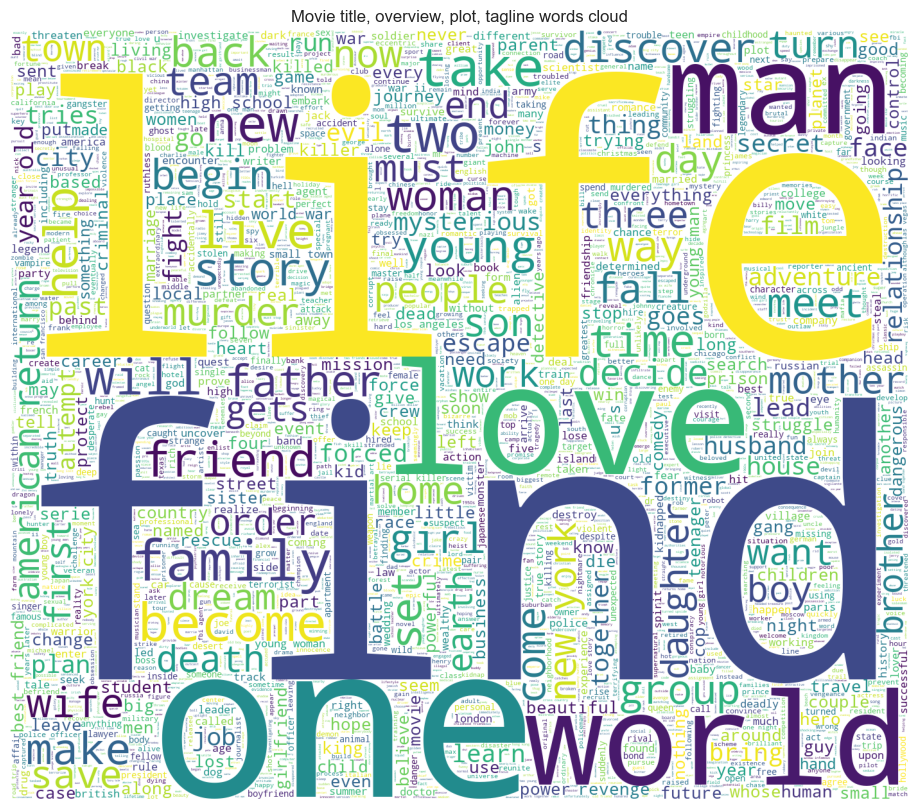

In [1232]:
text_columns = ['title', 'overview', 'plot', 'tagline']
text_data= df[text_columns].apply(lambda x: ' '.join(x), axis=1) 

text = ' '.join(text_data.astype(str))
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          max_words=10000,
                          width=1400,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('Movie title, overview, plot, tagline words cloud')
plt.axis('off')
plt.show()

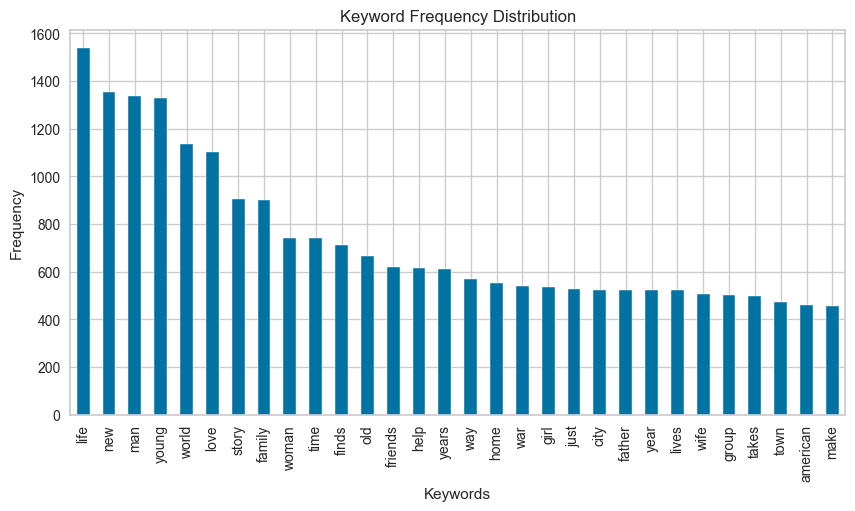

In [1233]:
vectorizer = TfidfVectorizer(max_features=300, stop_words='english') 
tfidf_matrix = vectorizer.fit_transform(text_data)  

keywords = vectorizer.get_feature_names_out()  # Get the keywords
binary_features = (tfidf_matrix > 0).astype(int)  

binary_features_df = pd.DataFrame(binary_features.toarray(), columns=keywords)  
keyword_frequencies = binary_features_df.sum(axis=0)  # Sum each column to get keyword frequencies

keyword_frequencies.sort_values(ascending=False).head(30).plot(kind='bar', figsize=(10, 5))
plt.title('Keyword Frequency Distribution')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

#### Time

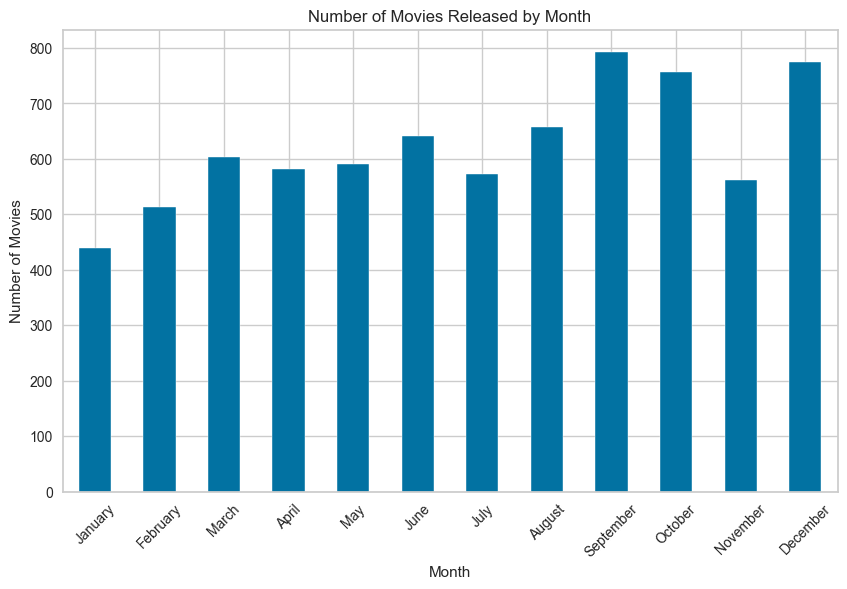

In [1234]:
month_counts = df['release_month'].value_counts().sort_index()
month_counts.plot(kind='bar', figsize=(10,6))

plt.title('Number of Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(12), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
plt.show()

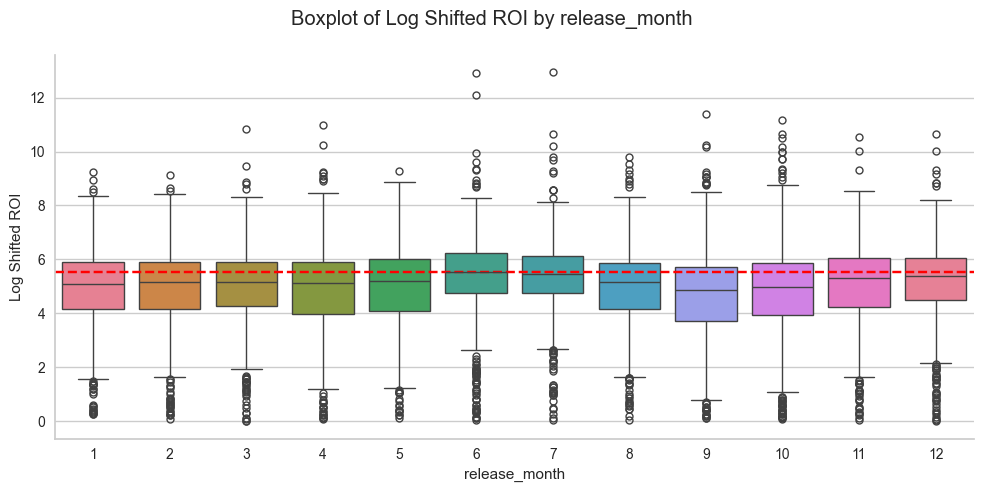

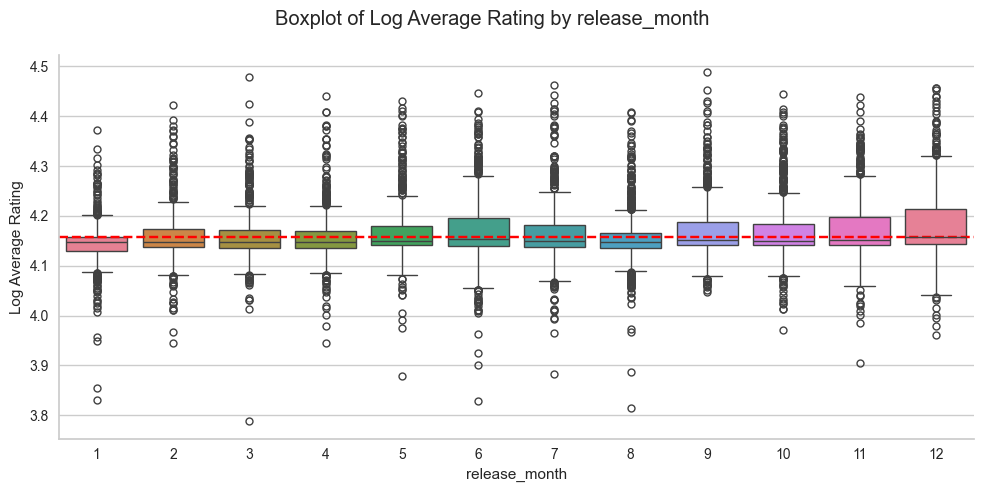

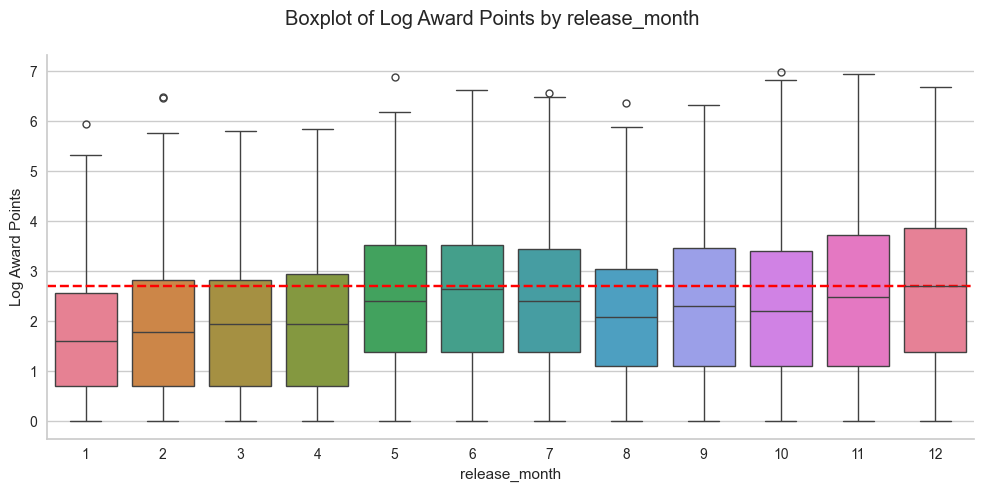

In [1235]:
def create_boxplot(data, variable, ylabel, group_column):
    g = sns.catplot(x=group_column, y=variable, kind='box', data=data, height=5, aspect=2, palette='husl', hue='release_month', legend=False)

    g.set_axis_labels(f'{group_column}', ylabel)
    g.fig.suptitle(f'Boxplot of {ylabel} by {group_column}')

    # Calculate the median values for each month
    medians = data.groupby(group_column)[variable].median()

    # Find the highest median value
    highest_median = medians.max()

    g.ax.axhline(y=highest_median, color='red', linestyle='--')

    plt.tight_layout() 
    plt.show()

df['log_adjusted_ROI'] = np.log(df['shifted_ROI'])
df['log_average_rating'] = np.log(df['average_rating'])
df['log_award_points'] = np.log(df['award_points'] + 1)

create_boxplot(df, 'log_adjusted_ROI', 'Log Shifted ROI', 'release_month')
create_boxplot(df, 'log_average_rating', 'Log Average Rating', 'release_month')
create_boxplot(df, 'log_award_points', 'Log Award Points', 'release_month')


#### ROI (Return On Investment):

- The highest median ROI is observed in the month of June, followed by July, December, and November.
- The lowest median ROI is seen in the month of September, followed by October, January, and August.
- There's a significant increase in median ROI starting from May, peaking in June, and then gradually decreasing, but remaining relatively high through July, November, and December.

#### Rating:

- The highest median rating is observed in December, with a noticeable drop in other months.
- The median rating values are fairly consistent across other months.

#### Awards:

- The highest median awards are observed in December, followed by June.
- There's a noticeable increase in median awards starting from May, peaking in June and December.
- The lowest median awards are observed in January and February.

Based on these observations, a possible way to create a 'seasons' feature could be as follows:

* Winter: January, and February - These months show a peak in ratings and awards, and a trough in ROI (except December).
* Spring: March and April - These months show a moderate level in all three labels.
* Summer: May, June, and July - These months show a peak in ROI and awards.
* Fall: August, September, October, and November - These months show a trough in ROI and a moderate level in ratings and awards, with a spike in ROI in November.

In our dataset, we see some interesting trends related to the month of December. Specifically, December showed the highest median rating and the highest median number of awards among all months. Additionally, the Return on Investment (ROI) in December was also relatively high, being one of the top performing months.

These trends suggest that December is a special month when it comes to movie performance metrics. One possible explanation for this could be the holiday season. December is a month full of holidays, including Christmas and New Year's Eve, which could lead to higher movie attendance and potentially more awards and higher ratings for movies released during this time.

Text(0.5, 1.0, 'Boxplot of log ROI by seasons')

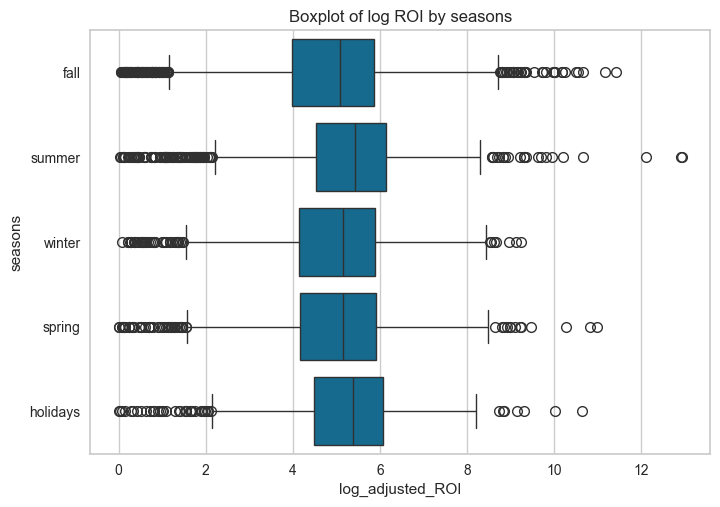

In [1236]:
def get_season(month):
    if month in [1, 2]:
        return 'winter'
    elif month == 12:
        return 'holidays'
    elif month in [3, 4]:
        return 'spring'
    elif month in [5, 6, 7]:
        return 'summer'
    else:
        return 'fall'

df['seasons'] = df['release_month'].apply(get_season)

ax = sns.boxplot(x=(df["log_adjusted_ROI"]), y=df['seasons'])
plt.title(f'Boxplot of log ROI by seasons')


Text(0.5, 1.0, 'Boxplot of log Average Raiting by seasons')

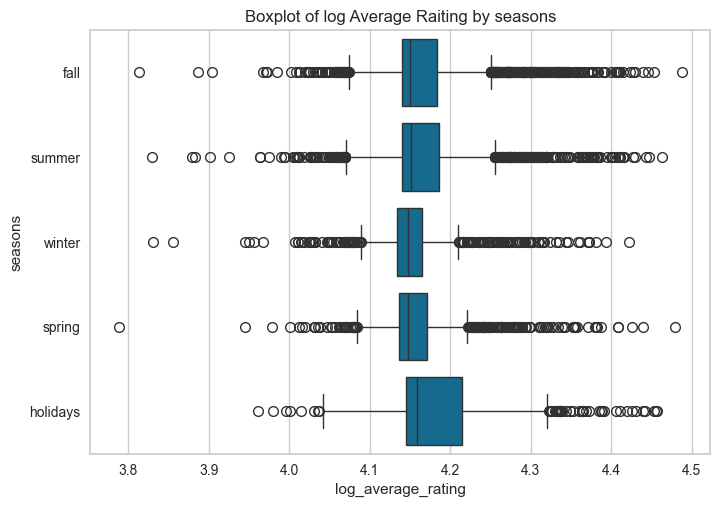

In [1237]:
ax = sns.boxplot(x=(df["log_average_rating"]), y=df['seasons'])
plt.title(f'Boxplot of log Average Raiting by seasons')


Text(0.5, 1.0, 'Boxplot of log Award Points by seasons')

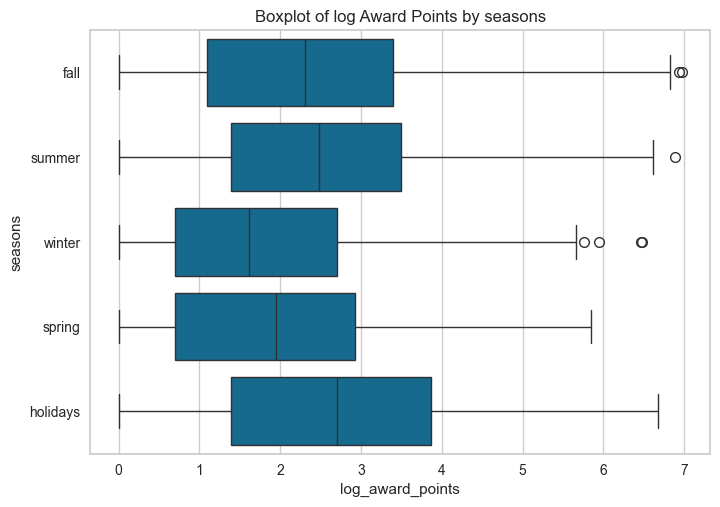

In [1238]:

ax = sns.boxplot(x=(df["log_award_points"]), y=df['seasons'])
plt.title(f'Boxplot of log Award Points by seasons')

In [1239]:
seasons_dummies = df['seasons'].str.get_dummies(sep=',')
df = pd.concat([df, seasons_dummies], axis=1)


#### Genres

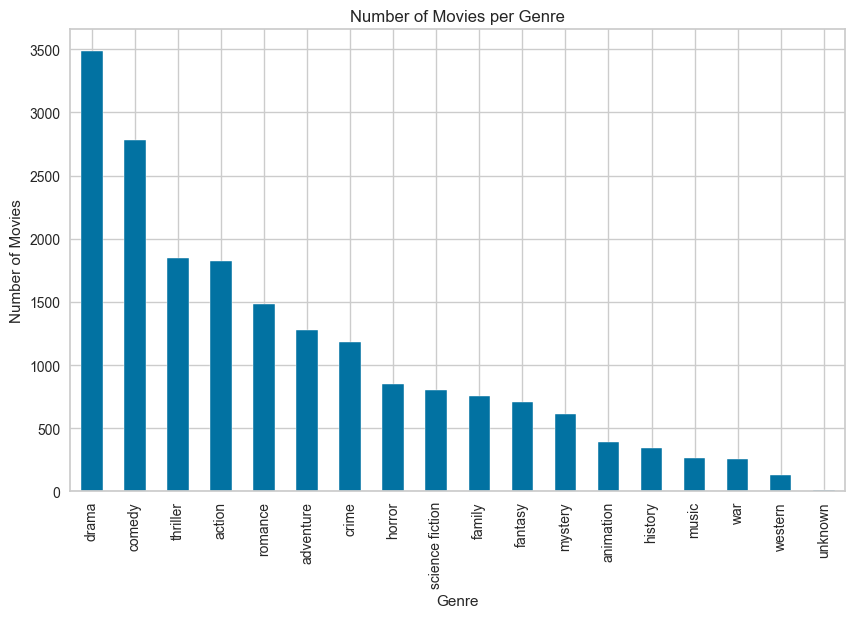

In [1240]:
genre_list = df['genres'].str.split(',', expand=True).stack()
genre_counts = genre_list.value_counts()
genre_counts.plot(kind='bar', figsize=(10,6))

plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

plt.show()


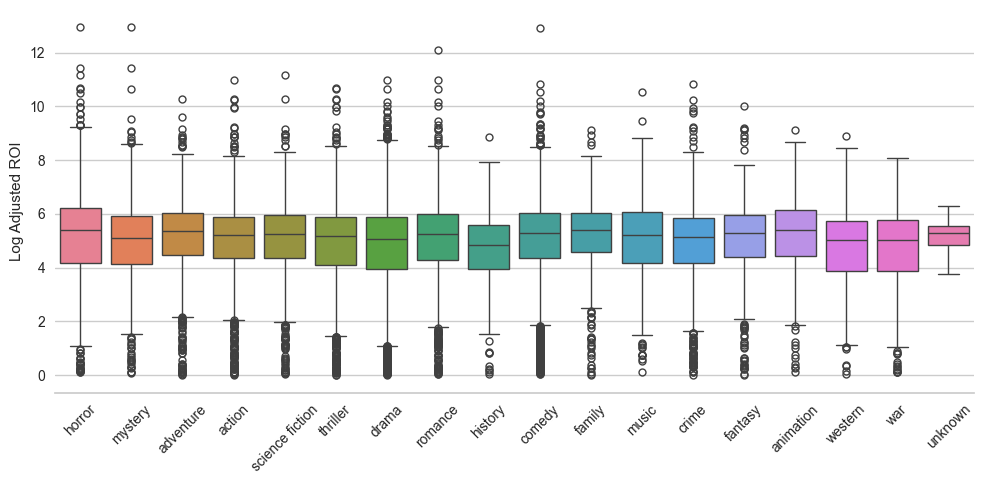

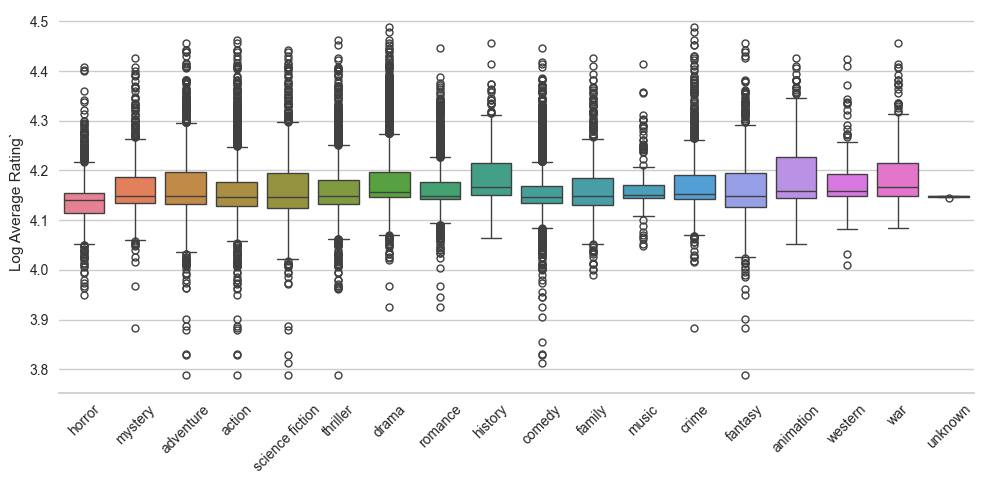

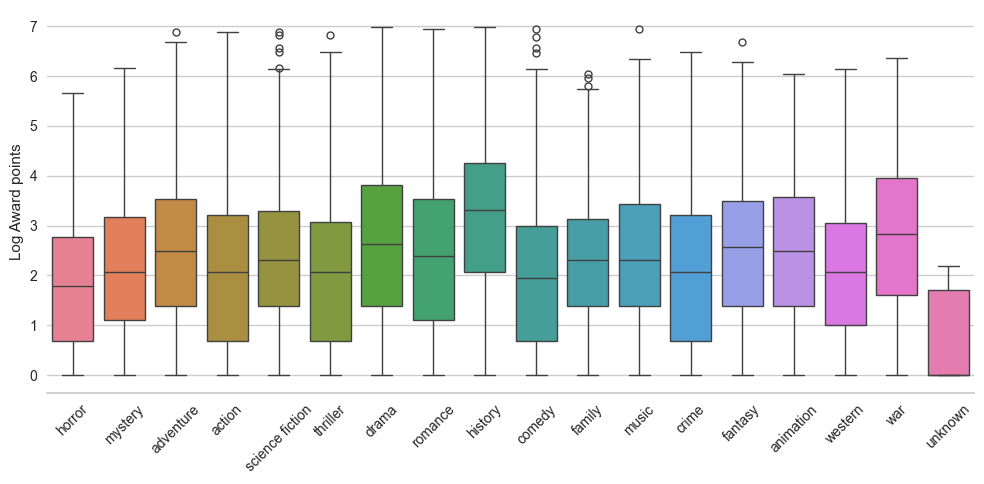

In [1241]:
genre_list = df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre')
df_genre_split = df.join(genre_list).reset_index(drop=True)
g = sns.catplot(x="genre", y='log_adjusted_ROI', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Adjusted ROI")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()

g = sns.catplot(x="genre", y='log_average_rating', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Average Rating`")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()


g = sns.catplot(x="genre", y='log_award_points', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="genre", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Award points")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()





#### High Performing Genres (across all metrics):

- Animation: Exhibits a higher median ROI, a relatively higher median rating, and a good median awards count.
- Family: Similar to Animation, Family genre also has a higher median ROI and a decent median awards count.
- Horror: Although horror has a lower median rating, it has a high median ROI and a lower median awards count, indicating it might be commercially successful but not critically acclaimed.

#### Critically Acclaimed Genres:

- History: Despite having the lowest median ROI, this genre has the highest median awards count and a high median rating, indicating critical acclaim.
- Drama: Drama also has a high median awards count and a relatively higher median rating despite a moderate median ROI.
- War: War genre has a high median awards count and a high median rating with a moderate median ROI.

#### Moderate Performing Genres:

Adventure, Comedy, Fantasy, Romance, Science Fiction, and Thriller: These genres exhibit a moderate performance across all three metrics (ROI, rating, and awards). They can be considered separately or grouped together under a "Moderate Performing" category.

#### Low Performing or Less Represented Genres:

Crime, Western, and Unknown: These genres have lower median values across all three metrics, and the 'unknown' genre especially has the lowest representation. They might be grouped together as "Others" 

#### Others:

Genres like Music, Mystery, and Action have mixed performance across the three metrics and could be grouped together under an "Others" category.

Let's set Adventure, Comedy, Fantasy, Romance, Science Fiction, and Thriller as a separate category "moderate performing". Music, Mystery, Action, Crime, Western, and Unknown as "others" and then create dummies from the genres column

In [1242]:
def replace_genre(genre_string):
    genre_string = genre_string.replace('adventure', 'moderate performing')
    genre_string = genre_string.replace('comedy','moderate performing')
    genre_string = genre_string.replace('fantasy', 'moderate performing')
    genre_string = genre_string.replace('romance', 'moderate performing')
    genre_string = genre_string.replace('science fiction', 'moderate performing')
    genre_string = genre_string.replace('thriller', 'moderate performing')
    genre_string = genre_string.replace('crime', 'others')
    genre_string = genre_string.replace('western', 'others')
    genre_string = genre_string.replace('unknown', 'others')
    genre_string = genre_string.replace('music', 'others')
    genre_string = genre_string.replace('mystery', 'others')
    genre_string = genre_string.replace('action', 'others')
    return genre_string

df['genres'] = df['genres'].apply(replace_genre)

genre_dummies = df['genres'].str.get_dummies(sep=',')
df = pd.concat([df, genre_dummies], axis=1)

#### Rated

In [1243]:
df['rated'].value_counts()

rated
r          2904
pg-13      1760
unrated    1250
pg         1106
g           221
other       209
nc-17        35
Name: count, dtype: int64

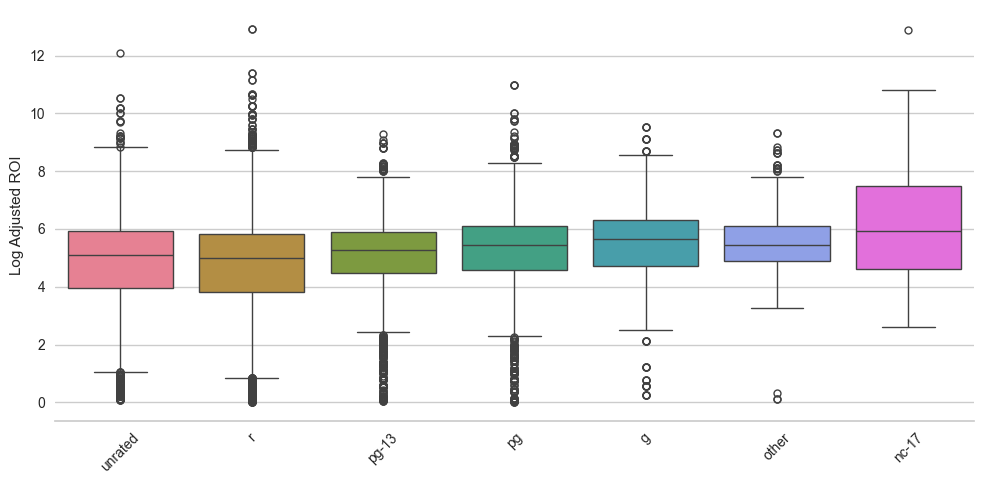

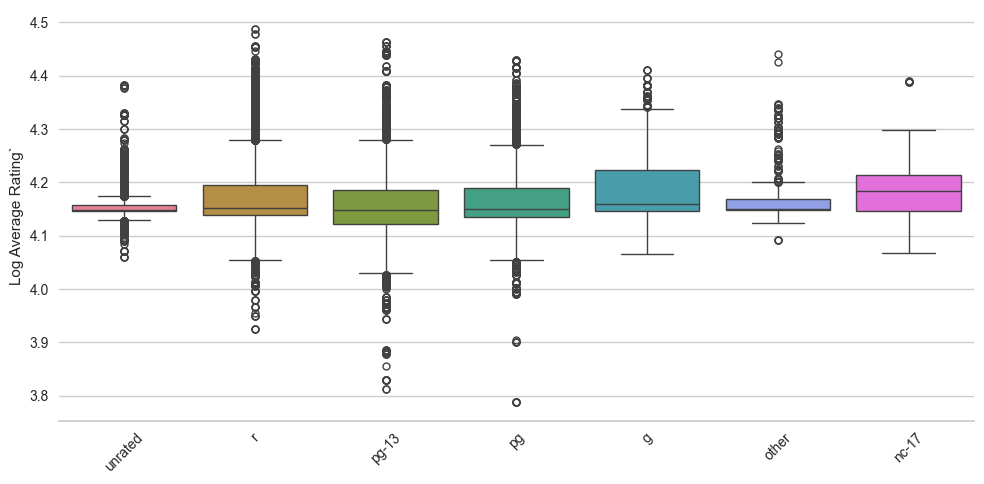

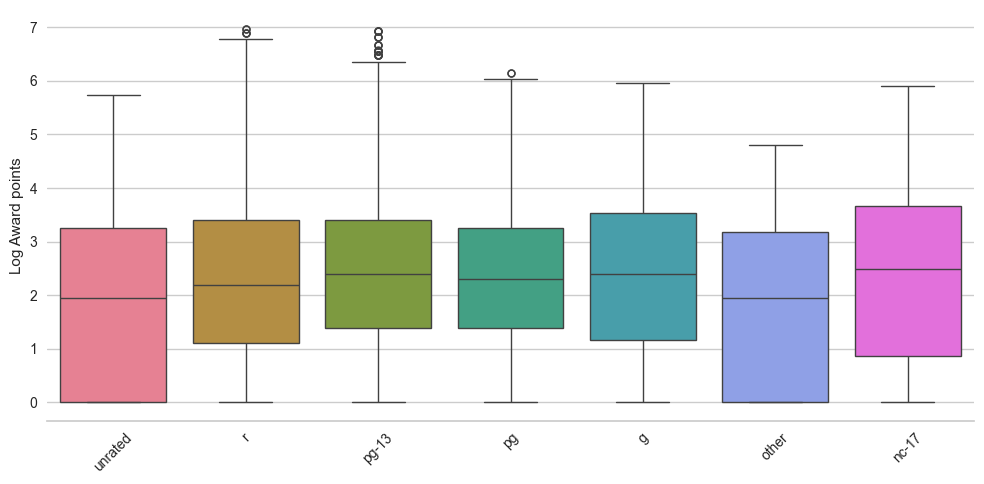

In [1244]:
g = sns.catplot(x="rated", y='log_adjusted_ROI', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Adjusted ROI")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()

g = sns.catplot(x="rated", y='log_average_rating', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Average Rating`")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()


g = sns.catplot(x="rated", y='log_award_points', kind='box', data=df_genre_split, height=5, aspect=2, palette='husl', hue="rated", legend=False)
g.despine(left=True)
g.set_axis_labels("", "Log Award points")
g.set_xticklabels(rotation=45)
plt.tight_layout() 
plt.show()



Films rated NC-17 have a higher median ROI compared to other ratings, while films rated G have a higher median in awards and a competitive median ROI.
On the other hand, films rated R have the lowest median ROI and a relatively low median in awards.

If some ratings like NC-17 or Unrated have significantly fewer entries compared to others, however, since NC-17 has a high median ROI, I would leave it as a separate rating, but I will combine Unrated and Others



In [1245]:
df['rated'] = df['rated'].replace('unrated', 'others')

#### List colums: spoken_languages, genres, production_companies, production_countries



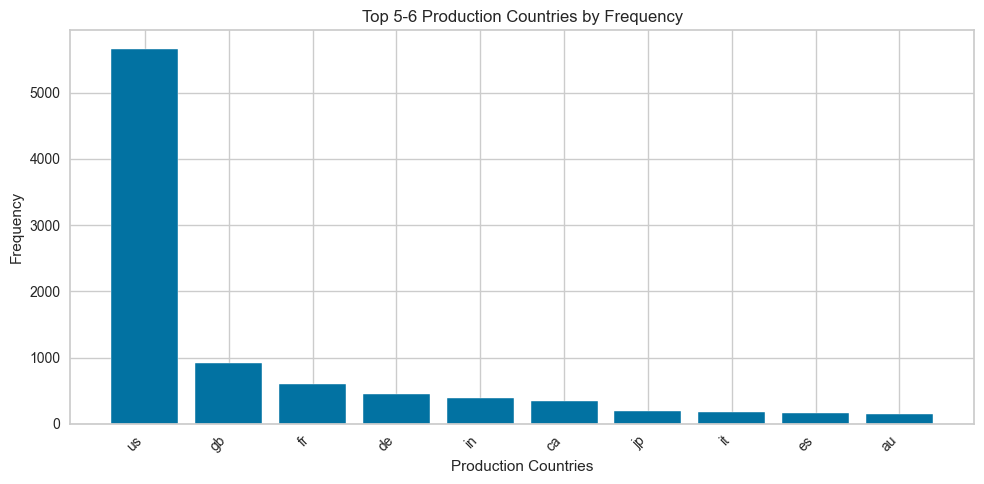

In [1246]:
production_c_df = df.copy()
production_c_df['production_countries'] = production_c_df['production_countries'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_countries'].dropna() for genre in genre_list)
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['production_countries', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies

top_countries = genre_frequencies.head(10)


plt.figure(figsize=(10, 5))
plt.bar(top_countries['production_countries'], top_countries['frequency'])
plt.xlabel('Production Countries')
plt.ylabel('Frequency')
plt.title('Top 5-6 Production Countries by Frequency')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

The majority of movies in the dataset are produced in the US

In [1247]:
empty_strings = df['production_companies'].value_counts().get('', 0)
print(f"Number of empty strings in column_name: {empty_strings}")

df['production_companies'] = df['production_companies'].replace('', 'no_company')


Number of empty strings in column_name: 0


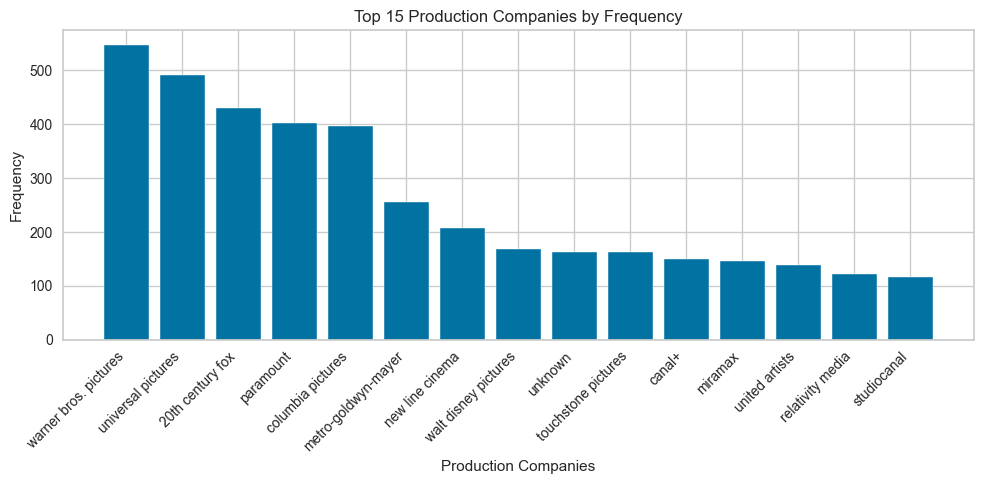

In [1248]:
production_c_df = df.copy()
production_c_df['production_companies'] = production_c_df['production_companies'].str.split(',')
genre_counter = Counter(genre for genre_list in production_c_df['production_companies'].dropna() for genre in genre_list)
production_companies = pd.DataFrame(genre_counter.items(), columns=['production_companies', 'frequency'])

production_companies = production_companies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
production_companies.head(10)

top_companies= production_companies.head(15)

plt.figure(figsize=(10, 5))
plt.bar(top_companies['production_companies'], top_companies['frequency'])
plt.xlabel('Production Companies')
plt.ylabel('Frequency')
plt.title('Top 15 Production Companies by Frequency')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()


In [1249]:
lang_df = df.copy()
lang_df['spoken_languages'] = lang_df['spoken_languages'].str.split(',')
genre_counter = Counter(genre for genre_list in lang_df['spoken_languages'].dropna() for genre in genre_list)
genre_frequencies = pd.DataFrame(genre_counter.items(), columns=['spoken_languages', 'frequency'])

genre_frequencies = genre_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
genre_frequencies.head(10)

spoken_languages  frequency
0               en       6349
1               fr        687
2               es        608
3               de        380
4               ru        372
5               it        360
6               hi        242
7               ja        235
8               zh        178
9               ar        118

And again the majority of movies in the datase uses english as spoken language

Let's add counts of languages, companies and countries as a new features

In [1250]:
df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x.split(',')) if x else 0)
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x.split(',')) if x else 0)
df[['num_spoken_languages', 'num_production_companies', 'num_production_countries']].describe()

num_spoken_languages  num_production_companies  \
count               7485.00                   7485.00   
mean                   1.46                      3.15   
std                    0.91                      2.28   
min                    1.00                      1.00   
25%                    1.00                      2.00   
50%                    1.00                      3.00   
75%                    2.00                      4.00   
max                   11.00                     30.00   

       num_production_countries  
count                   7485.00  
mean                       1.41  
std                        0.84  
min                        1.00  
25%                        1.00  
50%                        1.00  
75%                        2.00  
max                       12.00

And add is_foreign for those countries that are not US:

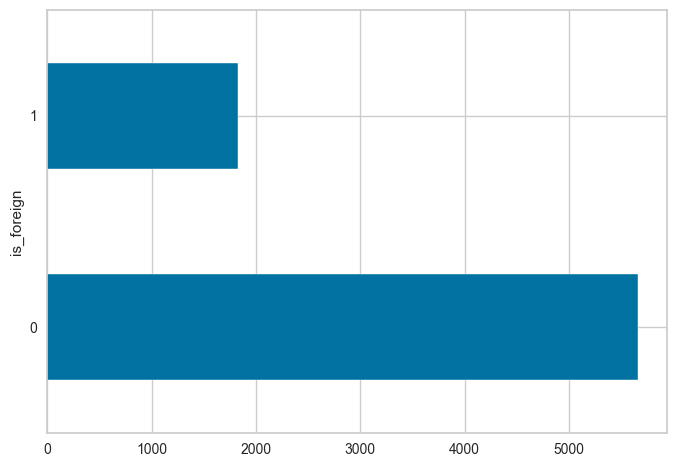

In [1251]:
df['is_foreign'] = df['production_countries'].apply(lambda x: 1 if 'us' not in x else 0)
df['is_foreign'].value_counts()
df['is_foreign'].value_counts().plot(kind='barh')
plt.show()

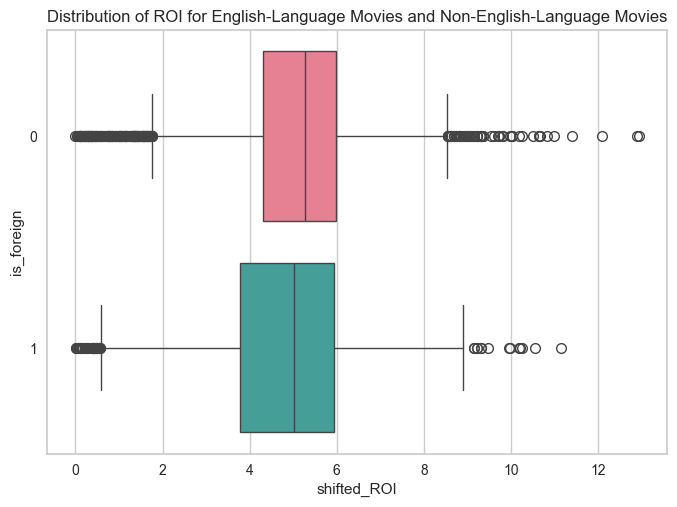

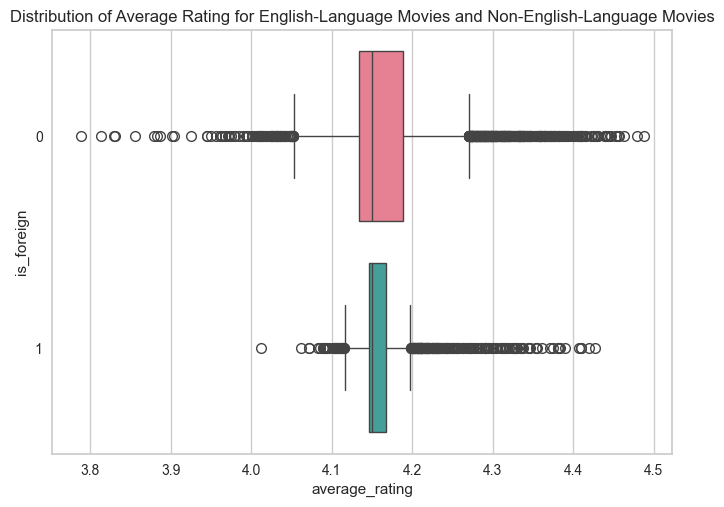

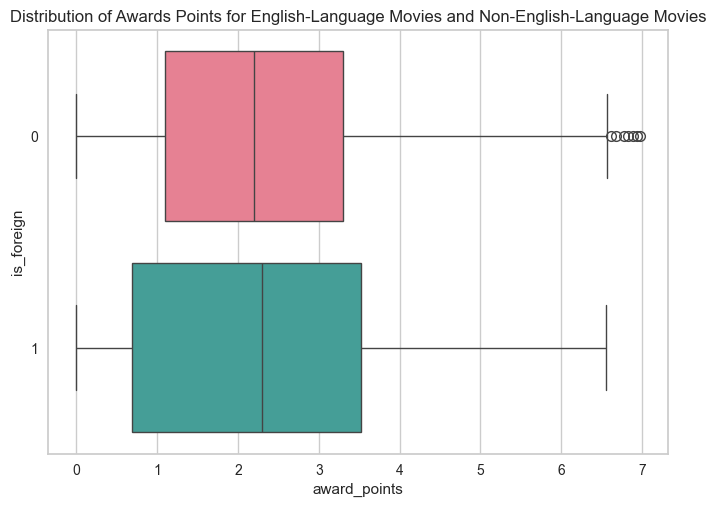

In [1252]:
is_foreign_string = df['is_foreign'].apply(lambda x: "1" if x==1 else "0")

ax = sns.boxplot(x=np.log(df['shifted_ROI']), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of ROI for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["average_rating"]), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of Average Rating for English-Language Movies and Non-English-Language Movies')
plt.show()

ax = sns.boxplot(x=np.log(df["award_points"] + 1), y=is_foreign_string, palette="husl", hue=is_foreign_string)
plt.title('Distribution of Awards Points for English-Language Movies and Non-English-Language Movies')
plt.show()

Domestic movies (indicated by is_foreign value 0) tend to have a higher median ROI compared to foreign movies. the is_foreign classification does not significantly impact the rating a movie receives and foreign movies have a slightly higher median award count of 9 compared to domestic movies.

The is_foreign feature can be utilized to understand or predict the financial success and award potential of movies, as there is a slight variation in ROI and awards count based on the domestic or foreign classification. However, its impact on ratings appears to be negligible.

#### Crew

For the 'crew' column, I'm focusing on the popularity of key figures in movie creation: the director, writer, and producer. Additionally, I'll calculate the 'average_crew_popularity' and the 'number of crew members' to represent the size and influence of the entire team.

In [1253]:
df['director_popularity'] = 0
df['director_popularity_list'] = df.apply(lambda x: [], axis=1)
df['director'] = df.apply(lambda x: [], axis=1)
df['writer'] = df.apply(lambda x: [], axis=1)
df['writer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['producer'] = df.apply(lambda x: [], axis=1)
df['producer_popularity_list'] = df.apply(lambda x: [], axis=1)
df['writer_popularity'] = 0
df['producer_popularity'] = 0
df['average_crew_popularity'] = 0
df['number_crew_members'] = 0

def update_popularity(row):
    director = []
    director_popularity_list = []
    writer = []
    writer_popularity_list = []
    producer = []
    producer_popularity_list = []
    director_popularity = 0
    writer_popularity = 0
    producer_popularity = 0
    total_popularity = 0
    num_directors = 0
    num_writers = 0
    num_producers = 0
    num_crew_members = len(row['crew'])
    
    for member in row['crew']:
        job = member.get('job', '')
        name = member.get('name', '')
        popularity = member.get('popularity', 0)
        total_popularity += popularity
        
        if job == 'director':
            director.append(name)
            director_popularity += popularity
            director_popularity_list.append(popularity)
            num_directors += 1
        elif job in ['writer', 'screenplay']:
            writer.append(name)
            writer_popularity += popularity
            writer_popularity_list.append(popularity)
            num_writers += 1
        elif job == 'producer':
            producer.append(name)
            producer_popularity += popularity
            producer_popularity_list.append(popularity)
            num_producers += 1
    
    # Average the popularity for directors, writers, and producers if there are multiple
    director_popularity /= max(num_directors, 1)
    writer_popularity /= max(num_writers, 1)
    producer_popularity /= max(num_producers, 1)
    
    # Compute the average popularity for all crew members
    average_crew_popularity = total_popularity / max(num_crew_members, 1)
    
    return pd.Series([director, director_popularity, director_popularity_list, writer, writer_popularity_list,writer_popularity,producer,  producer_popularity_list, producer_popularity, average_crew_popularity, num_crew_members])

df[['director', 'director_popularity', 'director_popularity_list', 'writer', 'writer_popularity_list', 'writer_popularity', 'producer', 'producer_popularity_list','producer_popularity', 'average_crew_popularity', 'number_crew_members']] = df.apply(update_popularity, axis=1)

def calculate_top_individuals(role_column, popularity_column):
    rows_list = []
    for index, row in df.iterrows():
        for individual, popularity in zip(row[role_column], row[popularity_column]):
            rows_list.append({role_column: individual, 'popularity': popularity})
    role_df = pd.DataFrame(rows_list)
    role_popularity = role_df.groupby(role_column)['popularity'].agg(['mean', 'count'])
    role_popularity = role_popularity.sort_values(by='mean', ascending=False)

    return role_popularity

top_popularity_directors = calculate_top_individuals('director', 'director_popularity_list')
top_popularity_writers = calculate_top_individuals('writer', 'writer_popularity_list')
top_popularity_producers = calculate_top_individuals('producer', 'producer_popularity_list')

top_fr_directors =  top_popularity_directors.sort_values(by='count', ascending=False)
top_fr_writers =  top_popularity_writers.sort_values(by='count', ascending=False)
top_fr_producers =  top_popularity_producers.sort_values(by='count', ascending=False)


Let's look at the most popular key figures in our dataset

In [1254]:
top_popularity_directors_reset = top_popularity_directors.head(10).reset_index()
top_popularity_writers_reset = top_popularity_writers.head(10).reset_index()
top_popularity_producers_reset = top_popularity_producers.head(10).reset_index()
top_fr_directors_reset = top_fr_directors.head(10).reset_index()
top_fr_writers_reset = top_fr_writers.head(10).reset_index()
top_fr_producers_reset = top_fr_producers.head(10).reset_index()

combined_df = pd.concat([
    top_popularity_directors_reset, top_fr_directors_reset, top_popularity_writers_reset,  top_fr_writers_reset,
    top_popularity_producers_reset, top_fr_producers_reset
], axis=1)

combined_df.columns = [
    'Top Popularity Directors', 'Popularity','Frequency',
    'Top Frequency Directors', 'Popularity', 'Frequency',
    'Top Popularity Writers', 'Popularity','Frequency',
    'Top Frequency Writers', 'Frequency','Frequency',
    'Top Popularity Producers', 'Popularity','Frequency',
    'Top Frequency Producers', 'Frequency','Frequency',
]

combined_df.style


In [1255]:
df_director = df.explode('director')

top_directors_profit = df_director.groupby(['director'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_directors_awards = df_director.groupby('director')['award_points'].sum().sort_values(ascending=False).head(10)
top_directors_rating = df_director.groupby('director')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 directors by ROI", pd.DataFrame(top_directors_profit))
print("Top 10 directors by Award Points", top_directors_awards)
print("Top 10 directors by Average Rating", top_directors_rating)



Top 10 directors by ROI                  adjusted_ROI
director                     
daniel myrick       414298.50
eduardo sánchez     414298.50
gerard damiano      399900.00
rick salomon        178631.01
oren peli            89832.93
aureliano luppi      69741.50
mel welles           69741.50
floyd mutrux         58233.33
john waters          49900.00
travis cluff         42864.41
Top 10 directors by Award Points director
steven spielberg               3676
peter jackson                  2581
martin scorsese                2351
christopher nolan              2328
quentin tarantino              2141
david fincher                  1986
alejandro gonzález iñárritu    1979
ang lee                        1863
joel coen                      1839
clint eastwood                 1643
Name: award_points, dtype: int64
Top 10 directors by Average Rating director
frank darabont         88.94
francis ford coppola   88.12
christopher nolan      86.69
peter jackson          86.18
steven spielberg     

In [1256]:
df_writer = df.explode('writer')

top_writers_profit = df_writer.groupby(['writer'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_writers_awards = df_writer.groupby('writer')['award_points'].sum().sort_values(ascending=False).head(10)
top_writers_rating = df_writer.groupby('writer')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 writers by ROI", pd.DataFrame(top_writers_profit))
print("Top 10 writers by Award Points", top_writers_awards)
print("Top 10 writers by Average Rating", top_writers_rating)

Top 10 writers by ROI                    adjusted_ROI
writer                         
eduardo sánchez       414298.50
daniel myrick         414298.50
gerard damiano        399900.00
oren peli              89832.93
edward di lorenzo      69741.50
floyd mutrux           58233.33
don simpson            58233.33
john waters            49900.00
travis cluff           42864.41
chris lofing           42864.41
Top 10 writers by Award Points writer
peter jackson        2581
fran walsh           2581
philippa boyens      2436
christopher nolan    2314
quentin tarantino    2194
ethan coen           2115
joel coen            2115
james cameron        1706
eric roth            1706
damien chazelle      1584
Name: award_points, dtype: int64
Top 10 writers by Average Rating writer
frank darabont         88.94
mario puzo             88.12
francis ford coppola   88.12
jonathan nolan         86.69
christopher nolan      86.69
peter jackson          86.18
fran walsh             86.18
philippa boyens     

In [1257]:
df_producer = df.explode('producer')

top_producers_profit = df_producer.groupby(['producer'])['adjusted_ROI'].max().sort_values(ascending=False).head(10)
top_producers_awards = df_producer.groupby('producer')['award_points'].sum().sort_values(ascending=False).head(10)
top_producers_rating = df_producer.groupby('producer')['average_rating'].max().sort_values(ascending=False).head(10)
print("Top 10 producers by ROI", pd.DataFrame(top_producers_profit))
print("Top 10 producers by Award Points", top_producers_awards)
print("Top 10 producers by Average Rating", top_producers_rating)

Top 10 producers by ROI                adjusted_ROI
producer                   
robin cowie       414298.50
gregg hale        414298.50
louis peraino     399900.00
amir zbeda         89832.93
oren peli          89832.93
jason blum         89832.93
mel welles         69741.50
roger corman       69741.50
fouad said         58233.33
john waters        49900.00
Top 10 producers by Award Points producer
scott rudin         5296
arnon milchan       3964
kathleen kennedy    3823
steven spielberg    3144
eric fellner        2946
tim bevan           2911
kevin feige         2893
peter jackson       2811
brad pitt           2754
fran walsh          2436
Name: award_points, dtype: int64
Top 10 producers by Average Rating producer
niki marvin         88.94
albert s. ruddy     88.12
lorne orleans       86.69
christopher nolan   86.69
charles roven       86.69
emma thomas         86.69
barrie m. osborne   86.18
peter jackson       86.18
fran walsh          86.18
branko lustig       86.13
Name: avera

#### Cast

For the 'cast' column, I will calculate the 'average_cast_popularity' and the 'number of cast members' to understand the overall popularity and size of the cast involved in the movies.

In [1258]:
df['average_cast_popularity'] = 0
df['number_cast_members'] = 0

def update_cast_popularity(row):
    total_popularity = 0
    top_cast_popularity = 0
    num_cast_members = len(row['cast'])
    
    # Sort the cast members by popularity, in descending order
    sorted_cast = sorted(row['cast'], key=lambda x: x.get('popularity', 0), reverse=True)
    
    for idx, member in enumerate(sorted_cast):
        popularity = member.get('popularity', 0)
        total_popularity += popularity
    
    # Compute the average popularity for all cast members
    average_cast_popularity = total_popularity / max(num_cast_members, 1)
    
    return pd.Series([average_cast_popularity, num_cast_members])

df[['average_cast_popularity', 'number_cast_members']] = df.apply(update_cast_popularity, axis=1)
df[['average_cast_popularity', 'number_cast_members']].describe()

average_cast_popularity  number_cast_members
count                  7485.00              7485.00
mean                      6.13                35.70
std                       3.62                25.24
min                       0.60                 1.00
25%                       3.56                18.00
50%                       5.54                29.00
75%                       7.97                46.00
max                      44.34               348.00

#### Feature importance analysis

Let's start from correlation matrix between numerical features and labels.

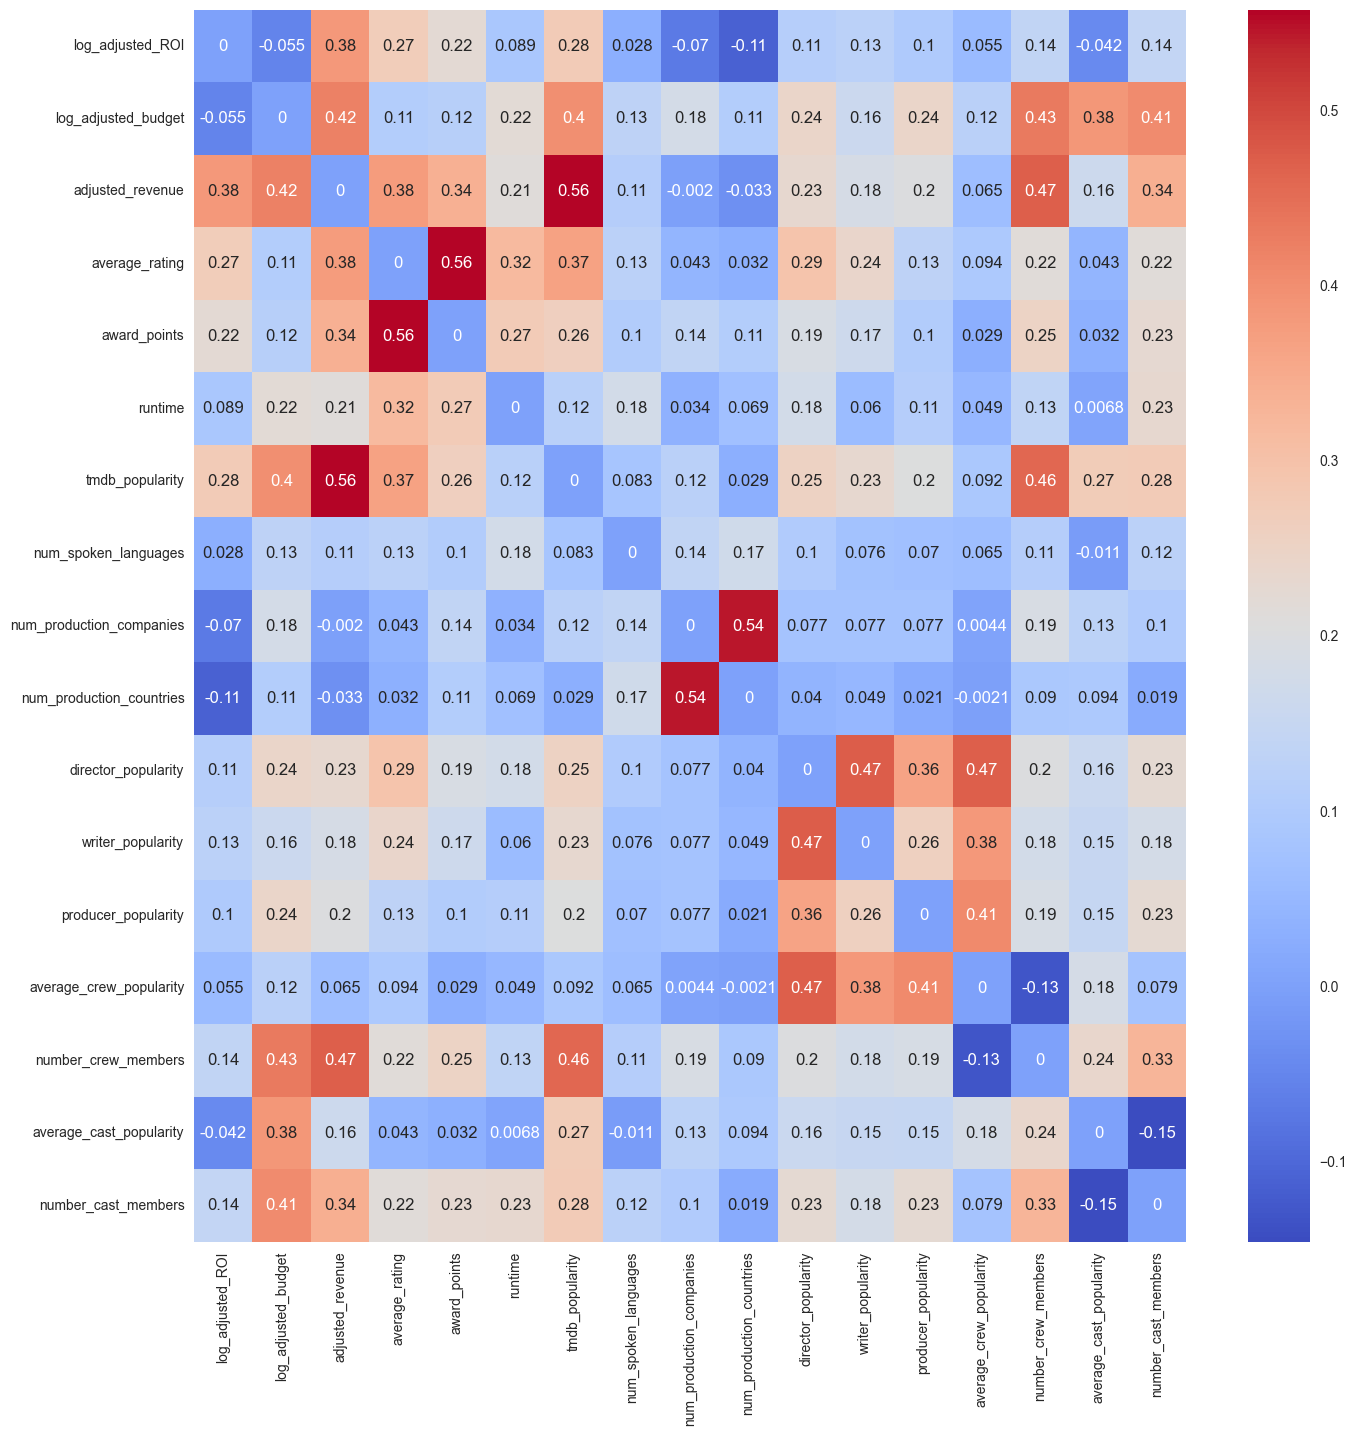

In [1259]:

corr_matrix = df[[ 'log_adjusted_ROI', "log_adjusted_budget", "adjusted_revenue", 
       'average_rating', 'award_points', 'runtime', 'tmdb_popularity',  'num_spoken_languages',
       'num_production_companies', 'num_production_countries', 
       'director_popularity', 
       'writer_popularity', 'producer_popularity', 'average_crew_popularity',
       'number_crew_members', 'average_cast_popularity', 'number_cast_members']].corr()

# Compute the correlation matrix for numerical features
for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i, i] = 0

plt.figure(figsize=(16, 16)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

* Ratings and Awards: Both average_rating and award_points correlate positively with adjusted_revenue, suggesting that higher-rated movies or those winning more awards tend to earn more.
* Popularity and Success: There's a noticeable correlation between tmdb_popularity and several success indicators like revenue and ROI, highlighting the role of popularity in a movie's financial performance. I've decided to remove tmdb_popularity from the analysis. This value is a complex calculation from the TMDB site, based on tmdb votes and ratings, and it could potentially interfere with the accuracy of our model.
* Crew and Cast Influence: The correlations involving director_popularity, writer_popularity, producer_popularity, and average_cast_popularity with various success measures indicate the significant impact of key crew and cast members on a movie's success.
* Size of Crew and Cast: The number_crew_members and number_cast_members also show correlations with financial measures, suggesting that the size of the production team and cast can influence a movie's performance.

I'm going to use two models, RandomForestClassifier and CatBoostClassifier, to find out which features are most important. [RandomForestClassifier](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f) is good for complex data, while [CatBoostClassifier](https://catboost.ai/en/docs/features/feature-importances-calculation) is great for data with categories, and both can show which features matter most. Both of them supports multilabel classification out of the box.

I'll split my data into training, validation, and test sets but will only check feature importance on the training set to keep things unbiased. I'll use [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) to turn text data into numbers and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to make sure all features are on a similar scale, which helps the models work better.

Since my dataset isn't evenly distributed across different labels, I'll use [iterative_train_test_split](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html). This method will help keep a balanced mix of labels in both training and test sets, ensuring my model's results are more accurate and fair. The idea behind this stratification method is to assign label combinations to folds based on how much a given combination is desired by a given fold, as more and more assignments are made, some folds are filled and positive evidence is directed into other folds, in the end negative evidence is distributed based on a folds desirability of size.

In [1260]:
dataset_df = df[[ 'runtime',
     'rated', 
     'collection',  
     'is_english',
     'log_adjusted_budget',
     'fall', 
     'holidays',
     'spring', 
     'summer', 
     'winter', 
     'animation', 
     'drama', 
     'family', 
     'history',
     'horror', 
     'moderate performing', 
     'others', 
     'war',
     'num_spoken_languages',
     'num_production_companies', 
     'num_production_countries', 
     'is_foreign',
     'director_popularity', 
     'writer_popularity', 
     'producer_popularity', 
     'average_crew_popularity',
     'number_crew_members', 
     'average_cast_popularity', 
     'number_cast_members',]].copy()

labels = df[["numerical_ROI_category", 'numerical_rating_category', 'numerical_award_category']]

X_np = dataset_df.to_numpy()
y_np = labels.to_numpy()

X_full_train, y_full_train, X_test, y_test = iterative_train_test_split(X_np, y_np, test_size = 0.2)
X_train, y_train, X_val, y_val = iterative_train_test_split(X_full_train, y_full_train, test_size = 0.25)

X_train_df = pd.DataFrame(X_train, columns=dataset_df.columns)  
X_val_df = pd.DataFrame(X_val, columns=dataset_df.columns)  

y_train_df = pd.DataFrame(y_train, columns=labels.columns) 
y_val_df = pd.DataFrame(y_val, columns=labels.columns)  

dv = DictVectorizer(sparse=False)
X_train_df_t = dv.fit_transform(X_train_df.to_dict(orient='records'))
X_val_df_t = dv.transform(X_val_df.to_dict(orient='records'))

# Scale the data
scaler = StandardScaler()
X_train_df_t = scaler.fit_transform(X_train_df_t)
X_val_df_t = scaler.transform(X_val_df_t)


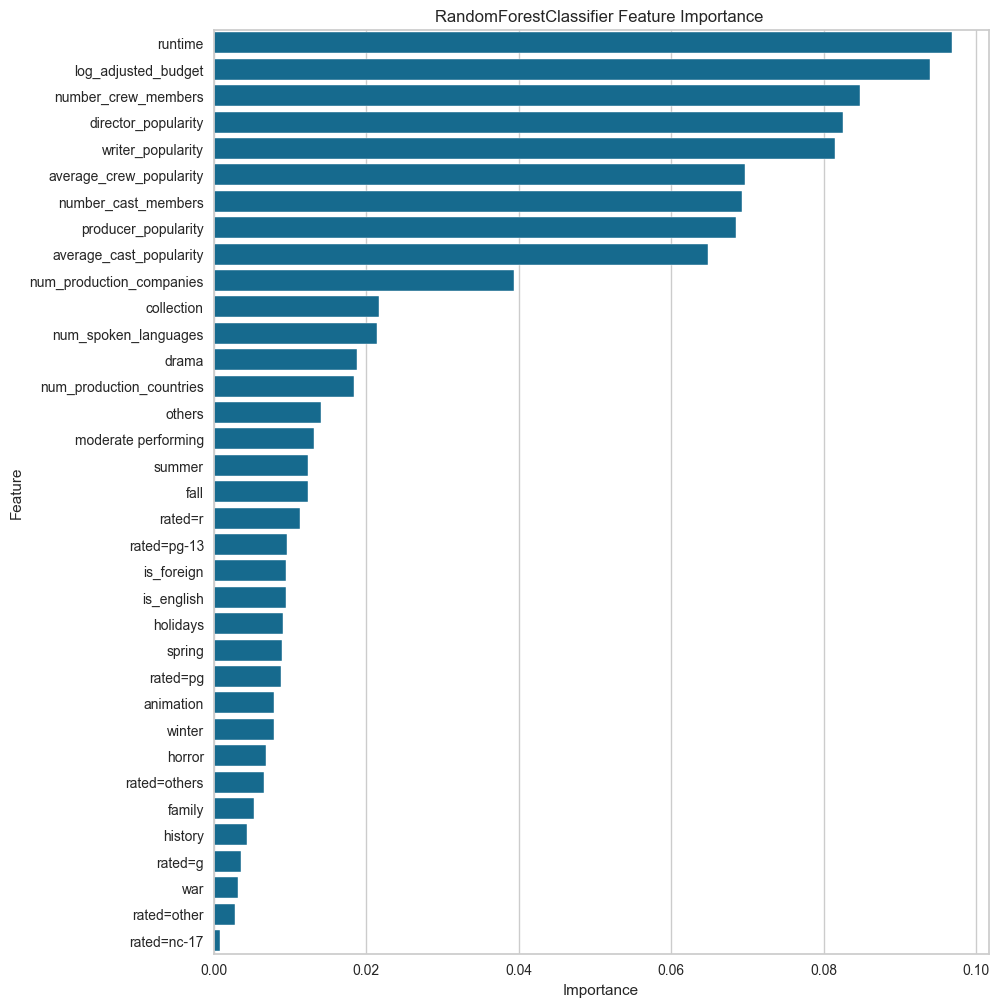

In [1261]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_df_t, y_train)

importances = random_forest_classifier.feature_importances_

feature_importances = pd.DataFrame({'feature': dv.get_feature_names_out(), 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x='importance', y='feature', data=feature_importances.sort_values('importance', ascending=False))
plt.title(f'RandomForestClassifier Feature Importance ')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

For the CatBoostClassifier, I'm using loss_function='MultiLogloss' and eval_metric='HammingLoss' due to the multilabel nature of my outputs.

MultiLogloss: This is a loss function suitable for multilabel classification tasks. It calculates the logarithmic loss for each label and then averages these values. It's effective in situations where each instance can belong to multiple labels simultaneously, as it penalizes wrong predictions more severely.

HammingLoss: Hamming Loss is a metric for evaluating multilabel classification models. It measures the fraction of the wrong labels to the total number of labels. This metric is useful because it accounts for the prediction error across all labels, providing a comprehensive view of the model's performance on multilabel data.

For more details about metrics for multilabel classification you can read this [post](https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.062085
0:	learn: 0.2260076	test: 0.2313516	best: 0.2313516 (0)	total: 224ms	remaining: 1m 51s
50:	learn: 0.1880056	test: 0.2108662	best: 0.2108662 (50)	total: 639ms	remaining: 5.62s
100:	learn: 0.1615824	test: 0.2064128	best: 0.2059675 (90)	total: 958ms	remaining: 3.79s
150:	learn: 0.1425072	test: 0.2026275	best: 0.2026275 (150)	total: 1.27s	remaining: 2.93s
200:	learn: 0.1239516	test: 0.2015141	best: 0.1997328 (180)	total: 1.62s	remaining: 2.41s
250:	learn: 0.1081422	test: 0.2006235	best: 0.1997328 (180)	total: 1.93s	remaining: 1.91s
300:	learn: 0.0930750	test: 0.2004008	best: 0.1995101 (270)	total: 2.24s	remaining: 1.48s
350:	learn: 0.0814963	test: 0.1995101	best: 0.1981741 (320)	total: 2.55s	remaining: 1.08s
400:	learn: 0.0728123	test: 0.1992875	best: 0.1981741 (320)	total: 2.84s	remaining: 702ms
450:	learn: 0.0662807	test: 0.2017368	best: 0.1981741 (320)	total: 3.15s	remaining: 343ms
499:	learn: 0.0596007	test: 0.2001781	best: 0.1981741 (320)	total: 3.45s	rem

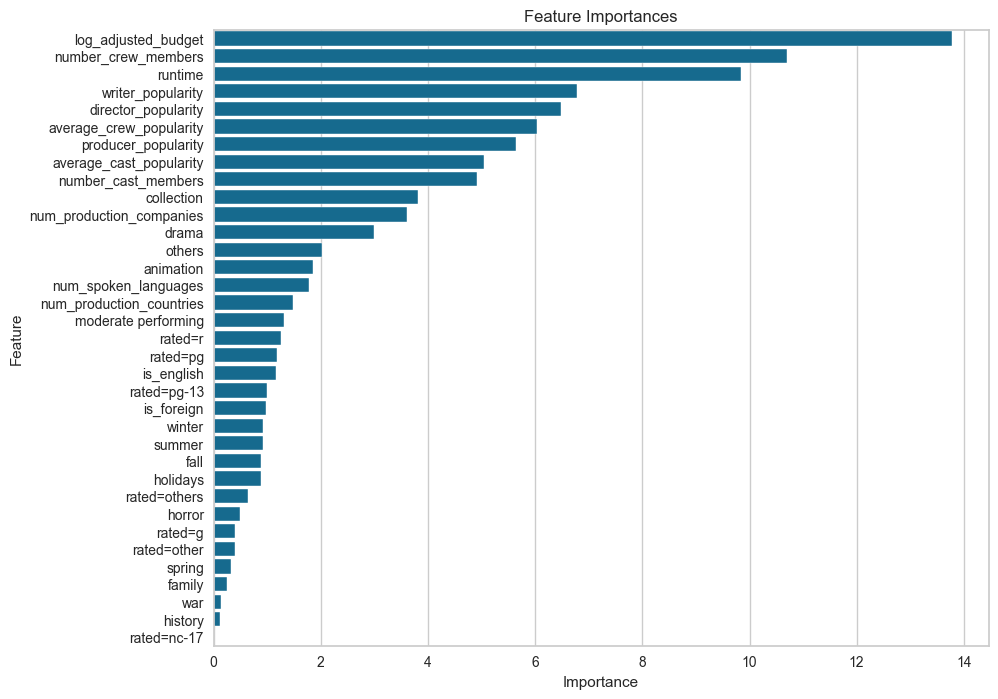

In [1262]:
train_pool = Pool(X_train_df_t, y_train)
val_pool = Pool(X_val_df_t, y_val)
catboost_classifier = CatBoostClassifier(loss_function='MultiLogloss',
    eval_metric='HammingLoss',
    iterations=500, random_state=1)
catboost_classifier.fit(train_pool, eval_set=val_pool, metric_period=10, plot=True, verbose=50)
feature_importances = catboost_classifier.get_feature_importance()

feature_names =  dv.get_feature_names_out() 
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()


After looking at which features are important, I've decided to drop 'rated', 'fall', 'holidays', 'spring', 'summer', 'family', 'history', 'horror', and 'war' from my models. They don't add much value, and the models show better result without them in the next Jupyter notebook.

In [1263]:
df[[ 'runtime',
      'collection',  
      'is_english',
      'log_adjusted_budget',
      'winter', 
      'animation', 
      'drama', 
      'moderate performing', 
      'others', 
      'num_spoken_languages',
      'num_production_companies', 
      'num_production_countries', 
      'is_foreign',
      'director_popularity', 
      'writer_popularity', 
      'producer_popularity', 
      'average_crew_popularity',
      'number_crew_members', 
      'average_cast_popularity', 
      'number_cast_members', 
      "numerical_ROI_category", 
      'numerical_rating_category', 
      'numerical_award_category'
      ]].to_parquet('../data/cleaned/selected_features.parquet')

With the feature selection complete, I have saved the chosen features into `../data/cleaned/selected_features.parquet`. Next, I'll be moving on to select and evaluate different models. This next step will be carried out in the [`/notebooks/3-Model.ipynb`](https://github.com/olgazju/ml_camp_2023/blob/main/midterm_project/notebooks/3-Model.ipynb) notebook, where I will explore various models to find the best fit for our data and objectives.